# **Trabajo Práctico 1**





# **Aprendizaje Automático 2**

**Facultad de Ciencias Exactas, Ingeniería y Agrimensura - TUIA**

**Alumnos:**


*   Ferrero Santiago
*   Loza Santiago



----------------------------------------------------------------------------------------------------------------------------------------------------------------

Enunciado: https://docs.google.com/document/d/1cp8cZrxhCjM5nm4AM8k1arh-bpLtT1-3/edit?rtpof=true#heading=h.gjdgxs

## Preparación del entorno.

Instalar gdown

In [1]:

!pip install -q gdown


Descargar los datasets:

In [2]:
import gdown

# TP1-1-student_performance.zip
gdown.download('https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc')

# TP1-2-Dry-Bean-Dataset.zip
gdown.download('https://drive.google.com/uc?id=1SUwYRZ_6ZWEQQ7FJxniqQCrnHCsBlQcJ')

# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 50.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SUwYRZ_6ZWEQQ7FJxniqQCrnHCsBlQcJ
To: /content/TP1-2-Dry-Bean-Dataset.zip
100%|██████████| 1.33M/1.33M [00:00<00:00, 25.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=7611a334-73a8-4748-b065-fce69561736d
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:11<00:00, 31.5MB/s]


'TP1-3-natural-scenes.zip'

Descomprimir datasets:

In [3]:
import zipfile

with zipfile.ZipFile('TP1-1-student_performance.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-1')

with zipfile.ZipFile('TP1-2-Dry-Bean-Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

Importamos las librerias necesarias

In [4]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout, Add
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomTranslation, RandomContrast

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error,mean_absolute_percentage_error

In [5]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

# Problema 1



En este problema, se presenta un conjunto de datos que contiene información sobre el rendimiento académico de estudiantes universitarios, así como diversos factores que podrían influir en él. El objetivo es construir un modelo de regresión utilizando redes neuronales para predecir el índice de rendimiento académico de los estudiantes basado en las características proporcionadas.


In [73]:
# Cargamos el dataset Student_Performance
Student_Perf = pd.read_csv("TP1-1/Student_Performance.csv")

In [74]:
Student_Perf.head(20)

Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0               7               99                        Yes            9   
1               4               82                         No            4   
2               8               51                        Yes            7   
3               5               52                        Yes            5   
4               7               75                         No            8   
5               3               78                         No            9   
6               7               73                        Yes            5   
7               8               45                        Yes            4   
8               5               77                         No            8   
9               4               89                         No            4   
10              8               91                         No            4   
11              8               79                         No            6   
12              3               47                         No            9   
13              6               47                         No            4   
14              5               79                         No            7   
15              2               72                         No            4   
16              8               73                        Yes            8   
17              6               83                        Yes            7   
18              2               54                        Yes            4   
19              5               75                         No            7   

    Sample Question Papers Practiced  Performance Index  
0                                  1               91.0  
1                                  2               65.0  
2                                  2               45.0  
3                                  2               36.0  
4                                  5               66.0  
5                                  6               61.0  
6                                  6               63.0  
7                                  6               42.0  
8                                  2               61.0  
9                                  0               69.0  
10                                 5               84.0  
11                                 2               73.0  
12                                 2               27.0  
13                                 2               33.0  
14                                 8               68.0  
15                                 3               43.0  
16                                 4               67.0  
17                                 2               70.0  
18                                 9               30.0  
19                                 0               63.0

In [75]:
Student_Perf.shape

(10000, 6)

In [76]:
Student_Perf.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

**Variables:**

*   `Hours Studied`: El número total de horas dedicadas al estudio por cada estudiante.
*   `Previous Scores`: Las puntuaciones obtenidas por los estudiantes en exámenes previos.
*   `Extracurricular Activities`: Si el estudiante participa en actividades extracurriculares (Sí o No).
*   `Sleep Hours`: El número promedio de horas de sueño que el estudiante tuvo por día.
*   `Sample Question Papers Practiced`: El número de cuestionarios de muestra que el estudiante practicó.

**Variable Objetivo:**

*   `Performance Index`: Un índice que representa el rendimiento académico general de cada estudiante, redondeado al entero más cercano. Este índice varía de 10 a 100, donde valores más altos indican un mejor rendimiento.


### **Analisis exploratorio**

En primer lugar, dividiremos nuestro set de datos en Train (80%) y Test (20%).

In [77]:
#Seleccionamos nuestras variables
X = Student_Perf[['Hours Studied', 'Previous Scores', 'Extracurricular Activities', 'Sleep Hours', 'Sample Question Papers Practiced']]
y = Student_Perf['Performance Index'] # Variable a predecir

In [78]:
# Dividimos los datos en conjunto de entrenamiento (80%) y conjunto de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [79]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000,), (2000,))

In [80]:
#Obtenemos el df de entrenamiento completo
Student_Perf_train = pd.concat([X_train, y_train], axis=1)

In [81]:
#Funcion que toma un df y devuelve los datos estadisticos de sus columnas
def datos_estadisticos(df):
  cols = df.columns
  for col in cols:
      print("--------------------")
      print("Columna: ", col)
      print("Cantidad de valores nulos: ", df[col].isnull().sum())
      print("Cantidad de valores únicos: ", df[col].nunique())
      print("Tipo de dato: ", df[col].dtype)
      # Si no es numérica, continuar con la siguiente columna
      if df[col].dtype == "object":
          print("--------------------")
          continue
      # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
      if df[col].nunique() < 11:
          print("Valores únicos: ", df[col].unique())
          print("Cantidad de veces que aparece cada valor: ", df[col].value_counts())
      else:
          # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
          print("Media: ", df[col].mean())
          print("Desvío estándar: ", df[col].std())
          print("Mínimo: ", df[col].min())
          print("Máximo: ", df[col].max())
      print("--------------------")


In [82]:
datos_estadisticos(Student_Perf_train)

--------------------
Columna:  Hours Studied
Cantidad de valores nulos:  0
Cantidad de valores únicos:  9
Tipo de dato:  int64
Valores únicos:  [1 7 2 4 8 9 3 5 6]
Cantidad de veces que aparece cada valor:  Hours Studied
1    925
3    904
9    895
7    892
6    888
4    877
8    877
2    874
5    868
Name: count, dtype: int64
--------------------
--------------------
Columna:  Previous Scores
Cantidad de valores nulos:  0
Cantidad de valores únicos:  60
Tipo de dato:  int64
Media:  69.56075
Desvío estándar:  17.335689348945728
Mínimo:  40
Máximo:  99
--------------------
--------------------
Columna:  Extracurricular Activities
Cantidad de valores nulos:  0
Cantidad de valores únicos:  2
Tipo de dato:  object
--------------------
--------------------
Columna:  Sleep Hours
Cantidad de valores nulos:  0
Cantidad de valores únicos:  6
Tipo de dato:  int64
Valores únicos:  [6 7 8 5 4 9]
Cantidad de veces que aparece cada valor:  Sleep Hours
8    1454
7    1343
6    1322
9    1314
5    1298

In [83]:
# Estadisticas
Student_Perf_train.describe()

Hours Studied  Previous Scores  Sleep Hours  \
count    8000.000000      8000.000000  8000.000000   
mean        4.984500        69.560750     6.544625   
std         2.594051        17.335689     1.695175   
min         1.000000        40.000000     4.000000   
25%         3.000000        55.000000     5.000000   
50%         5.000000        69.000000     7.000000   
75%         7.000000        85.000000     8.000000   
max         9.000000        99.000000     9.000000   

       Sample Question Papers Practiced  Performance Index  
count                       8000.000000        8000.000000  
mean                           4.595125          55.314750  
std                            2.862075          19.175013  
min                            0.000000          10.000000  
25%                            2.000000          40.000000  
50%                            5.000000          55.000000  
75%                            7.000000          71.000000  
max                            9.000000         100.000000

Como todas las columnas tienen 8000 registros vemos que no hay nulos, y además, podemos notar que los datos de las columnas coinciden con lo que representan. En base a ello, en principio, podriamos descartar valores atípicos.

In [84]:
# Chequemos si hay registros con valores nulos
Student_Perf_train.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [85]:
# Chequemos si hay registros duplicados
Student_Perf_train.duplicated().sum()

76

In [86]:
Student_Perf_train[Student_Perf_train.duplicated() == True]

Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
4083              8               53                         No            5   
6649              3               46                         No            7   
9499              5               70                        Yes            8   
2463              1               98                        Yes            8   
4096              3               53                         No            6   
...             ...              ...                        ...          ...   
8308              1               91                         No            6   
4212              7               87                        Yes            4   
2130              6               58                        Yes            9   
5351              7               54                         No            6   
915               9               52                         No            5   

      Sample Question Papers Practiced  Performance Index  
4083                                 1               49.0  
6649                                 7               26.0  
9499                                 2               55.0  
2463                                 2               75.0  
4096                                 2               31.0  
...                                ...                ...  
8308                                 2               64.0  
4212                                 7               78.0  
2130                                 9               50.0  
5351                                 7               44.0  
915                                  9               48.0  

[76 rows x 6 columns]

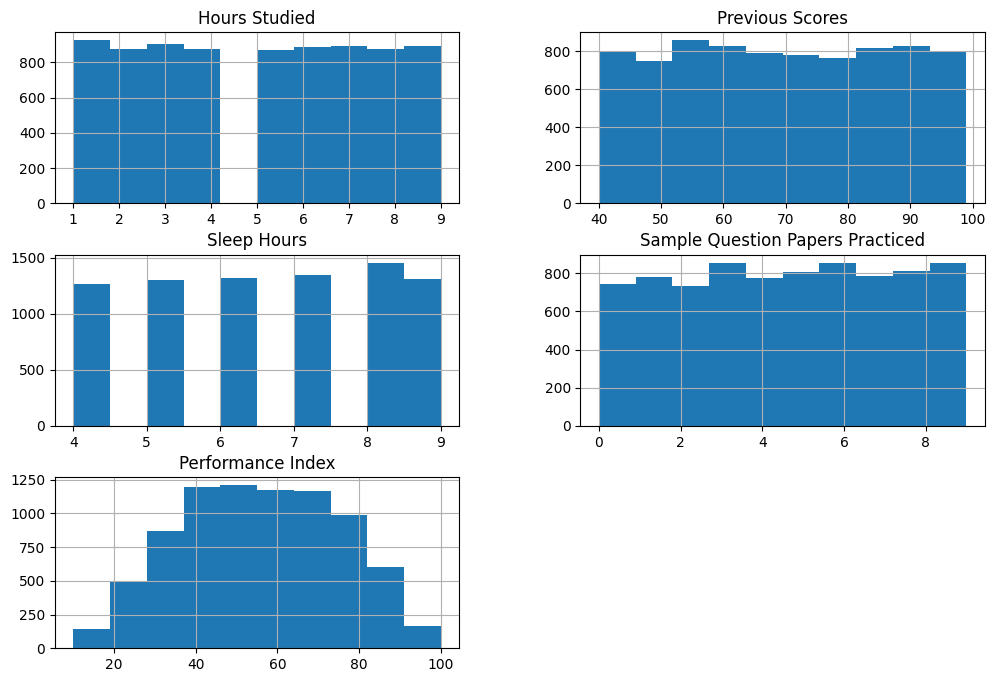

In [87]:
# Visualizamos los histogramas de las variables
Student_Perf_train.hist(figsize=(12, 8))
plt.show()

In [88]:
#La funcion toma una DF y columnas del mismo. Se encarga de generar boxplots de dichas columnas
def plot_boxplots(df, columns):
    # Creamos una figura de boxplots
    fig, axes = plt.subplots(1, len(columns), figsize=(12, 6))

    for i, column in enumerate(columns):
        # Generamos el gráfico de caja para la columna actual
        axes[i].boxplot(df[column])
        axes[i].set_title(column)
        axes[i].set_xticks([1])
        axes[i].set_xticklabels([column])

    plt.show()

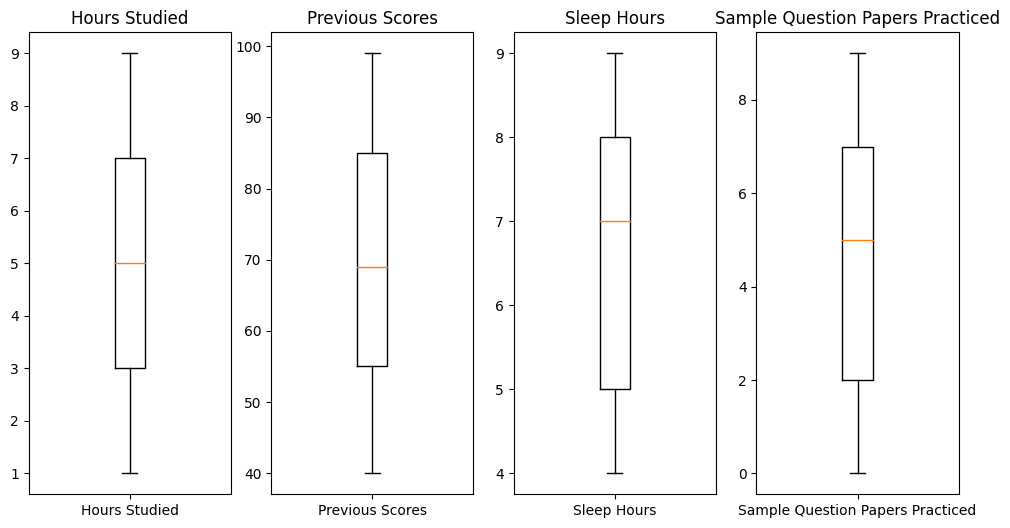

In [89]:
# Boxplots columnas 'Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced'
plot_boxplots(Student_Perf_train, ['Hours Studied', 'Previous Scores', 'Sleep Hours','Sample Question Papers Practiced'])

Los gráficos muestran la distribución de cuatro variables relacionadas con el rendimiento académico: `horas de estudio`,` puntajes previos`, `horas de sueño` y `cantidad de exámenes de práctica resueltos`.

*   `Horas de estudio y puntajes previos`: Ambas variables presentan un rango similar y una distribución bastante uniforme.

*   `Horas de sueño`: La mayoría de los estudiantes duermen entre 7 y 8 horas, con algunos valores inusuales por encima y por debajo de este rango.

*  `Exámenes de práctica`: Similar a las horas de sueño, la mayoría de los estudiantes resolvieron entre 2 y 8 exámenes de práctica, con algunos valores inusuales por encima y por debajo.





In [90]:
# Relación entre 'Hours Studied' y 'Performance Index'
Student_Perf_train.groupby('Hours Studied')['Performance Index'].mean()

Hours Studied
1    44.061622
2    46.902746
3    49.883850
4    53.188141
5    55.627880
6    58.202703
7    60.455157
8    64.581528
9    65.356425
Name: Performance Index, dtype: float64

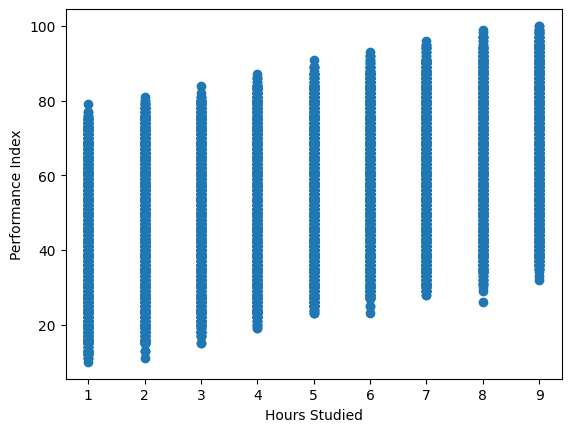

In [91]:
# Gráfico de relación entre 'Hours Studied' y 'Performance Index'
plt.scatter(Student_Perf_train['Hours Studied'], Student_Perf_train['Performance Index'])
plt.xlabel('Hours Studied')
plt.ylabel('Performance Index')
plt.show()

Podemos notar que, en promedio, a medida que aumentan las horas de sueño, crece el puntaje...

In [92]:
# Filtramos solo las columnas numéricas
numeric_cols = Student_Perf_train.select_dtypes(include='number')

# Calculamos la matriz de correlación para las variables numéricas
numeric_cols.corr()

Hours Studied  Previous Scores  Sleep Hours  \
Hours Studied                          1.000000        -0.018080    -0.010475   
Previous Scores                       -0.018080         1.000000     0.001403   
Sleep Hours                           -0.010475         0.001403     1.000000   
Sample Question Papers Practiced       0.022830         0.007996     0.005412   
Performance Index                      0.370571         0.914310     0.039686   

                                  Sample Question Papers Practiced  \
Hours Studied                                             0.022830   
Previous Scores                                           0.007996   
Sleep Hours                                               0.005412   
Sample Question Papers Practiced                          1.000000   
Performance Index                                         0.045328   

                                  Performance Index  
Hours Studied                              0.370571  
Previous Scores                            0.914310  
Sleep Hours                                0.039686  
Sample Question Papers Practiced           0.045328  
Performance Index                          1.000000

In [93]:
#Funcion que toma un df y devuelve la matriz de correlación de las variables
def corr(df):
    #Graficamos la matriz
    corr = df.corr()
    plt.figure(figsize=(15, 15))
    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True,
        annot = True,
        annot_kws = {'size': 6}
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()

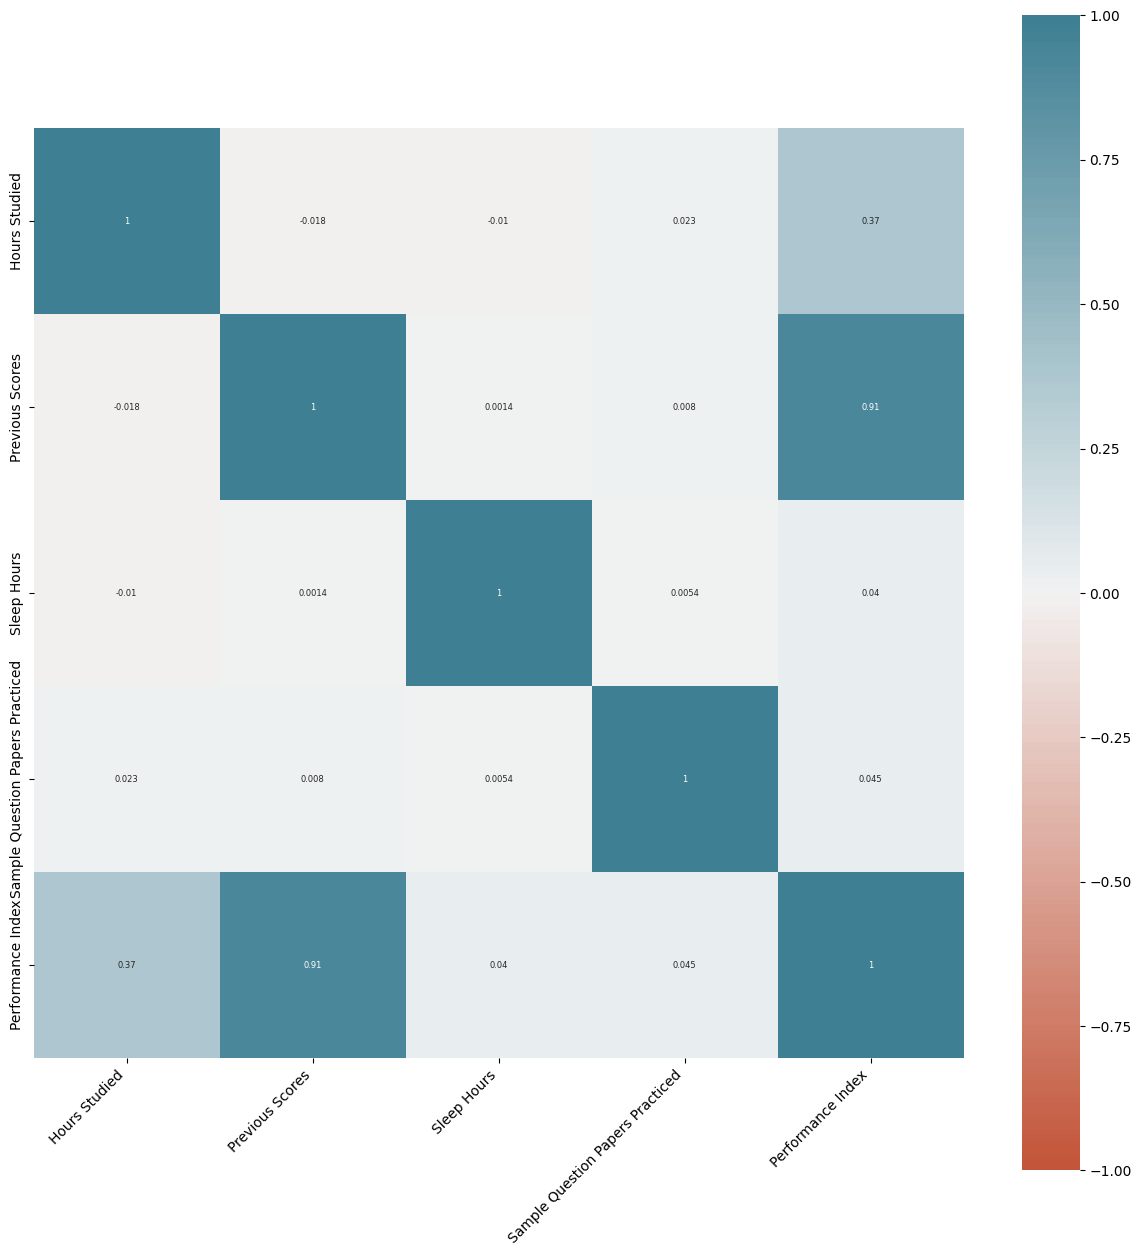

In [94]:
corr(numeric_cols)

Analizando los distintos niveles de correlación que hay entre las variables, podemos notar que el mas elevado se da entre `Previous Scores` y `Performance Index`

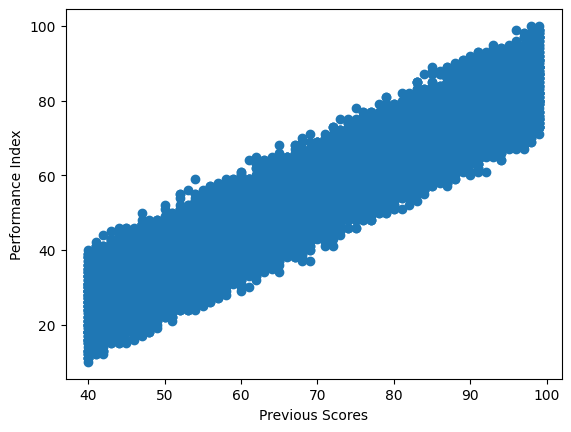

In [95]:
# Gráfico de relación entre 'Previous Scores' y 'Performance Index'
plt.scatter(Student_Perf_train['Previous Scores'], Student_Perf_train['Performance Index'])
plt.xlabel('Previous Scores')
plt.ylabel('Performance Index')
plt.show()

Se puede observar la clara relación entre las mismas.

### **Preprocesamiento**

In [96]:
#Funcion de preprocesamiento de los datos
def preprocess_data(x, y , variable_objetive):

    # Diccionario para mapear la variable categorica
    mapping = {'Yes': int(1), 'No': int(0)}

    # Aplicamos el mapeo a la columna 'Class'
    x.loc[:, 'Extracurricular Activities'] = x['Extracurricular Activities'].map(mapping)
    x['Extracurricular Activities'] = x['Extracurricular Activities'].astype(int)

    # Defino un diccionario para definir el tipo de dato de cada columna
    column_types = {
        "Hours Studied": "int64",
        "Previous Scores": "int64",
        "Extracurricular Activities": "int64",
        "Sleep Hours": "int64",
        "Sample Question Papers Practiced": "int64"
    }

    # Diccionario para almacenar media y desvío estándar de las columnas numéricas.
    numeric_stats = {}

    preprocessed_df = pd.DataFrame(x)

    # Preprocesamiento del set de entrenamiento
    for col_name, col_type in column_types.items():
      # Verifico si la columna está presente en el DataFrame
      if col_name in preprocessed_df.columns:
        # Obtengo el índice de la columna por su nombre
        col_values = preprocessed_df[col_name]
        col_mean = col_values.mean()
        col_std = col_values.std()

        # Normalizo la columna si es numérica
        if col_type == "int64":
            preprocessed_df[col_name] = (col_values - col_mean) / col_std

        # Almaceno media y desvío estándar
        numeric_stats[col_name] = {
            "mean": col_mean,
            "std": col_std
        }

    # Agrego la "variable_objetive" al dataset preprocesado
    preprocessed_df[variable_objetive] = y

    # Eliminamos valores nulos
    preprocessed_df = preprocessed_df.dropna()

    # x e y preprocesados
    x_processed = preprocessed_df.drop(variable_objetive, axis=1).values.astype(np.float32)
    y_processed = preprocessed_df[variable_objetive].values.astype(np.float32)

    return x_processed, y_processed

In [97]:
# Luego llamamos a la función para preprocesar los datos de entrenamiento
X_train, y_train = preprocess_data(X_train, y_train,'Performance Index')

### **Modelo**

In [98]:
#Preprocesamos los datos de test
X_test, y_test = preprocess_data(X_test, y_test,'Performance Index')

In [99]:
#Modelo
model1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5,)),                    # Numero de variables de entrada

    tf.keras.layers.Dense(units=10, activation='relu'),   # Capa oculta con 10 neuronas

    tf.keras.layers.Dense(units=5, activation='relu'),    # Capa oculta con 5 neuronas

    tf.keras.layers.Dense(units=1, activation='linear')   # Capa de salida con 1 neurona y activación lineal
])

# Optimizador Adam para el entrenamiento del modelo.
optimizer = tf.keras.optimizers.Adam()

# Se compila el modelo, configurando el optimizador, la función de pérdida y las métricas a utilizar.
model1.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.R2Score()]) #Como función de perdida utilizamos MSE y la métrica a optimizar el R2

# Resumen del modelo
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 10)                60        
                                                                 
 dense_10 (Dense)            (None, 5)                 55        
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min")

# Número de épocas de entrenamiento
EPOCHS = 15

# Entrena el modelo
history = model1.fit(x=X_train, y=y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/15
250/250 [==============================] - 6s 15ms/step - loss: 3252.6431 - r2_score: -7.8475 - val_loss: 2889.8357 - val_r2_score: -6.7119 - lr: 0.0010
Epoch 2/15
250/250 [==============================] - 3s 11ms/step - loss: 2283.9434 - r2_score: -5.2125 - val_loss: 1486.1965 - val_r2_score: -2.9661 - lr: 0.0010
Epoch 3/15
250/250 [==============================] - 2s 7ms/step - loss: 857.1407 - r2_score: -1.3315 - val_loss: 325.4566 - val_r2_score: 0.1315 - lr: 0.0010
Epoch 4/15
250/250 [==============================] - 2s 8ms/step - loss: 161.5882 - r2_score: 0.5605 - val_loss: 69.8053 - val_r2_score: 0.8137 - lr: 0.0010
Epoch 5/15
250/250 [==============================] - 2s 6ms/step - loss: 61.5823 - r2_score: 0.8325 - val_loss: 48.6836 - val_r2_score: 0.8701 - lr: 0.0010
Epoch 6/15
250/250 [==============================] - 2s 8ms/step - loss: 48.9858 - r2_score: 0.8668 - val_loss: 40.5898 - val_r2_score: 0.8917 - lr: 0.0010
Epoch 7/15
250/250 [====================

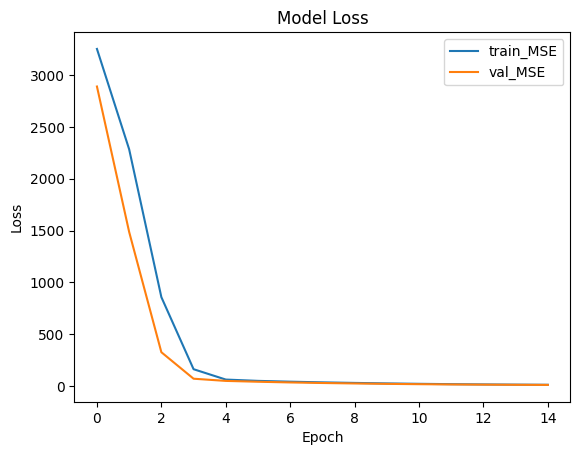

In [101]:
# Pérdida durante el entrenamiento
loss = history.history['loss']


# Gráfica de la pérdida en función de las épocas
plt.plot(loss, label = 'train_MSE')
plt.plot(history.history['val_loss'], label = 'val_MSE')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

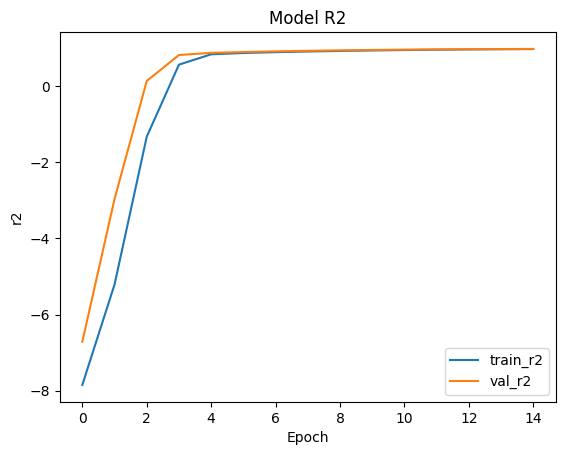

In [102]:
r2_train = history.history['r2_score']
r2_val = history.history['val_r2_score']

# Graficar la precisión
plt.plot(r2_train, label='train_r2')
plt.plot(r2_val, label='val_r2')
plt.title('Model R2')
plt.xlabel('Epoch')
plt.ylabel('r2')
plt.legend()
plt.show()

Podemos notar como con el paso de las épocas, las métricas del modelo mejoran notoriamente, observamos que las métricas con datos de validación se optimizan muy similarmente a las métricas con datos de entrenamiento.

**Métricas datos entrenamiento**

In [103]:
# Predicciones con los datos de entrenamiento
predictions_train = model1.predict(X_train)

# Imprimimos las métricas de entrenamiento
# Calcular y imprimir el Mean Squared Error (MSE)
mse = round(mean_squared_error(y_train, predictions_train), 5)
print(f"\nMean Squared Error (MSE): {mse}")

# Calcular y imprimir el Root Mean Squared Error (RMSE)
rmse = round(mean_squared_error(y_train, predictions_train, squared=False), 5)
print(f"\nRoot Mean Squared Error (RMSE): {rmse}")

# Calcular y imprimir el Mean Absolute Error (MAE)
mae = round(mean_absolute_error(y_train, predictions_train), 5)
print(f"\nMean Absolute Error (MAE): {mae}")

# Calcular y imprimir el Error Porcentual Absoluto Medio (MAPE)
mape = round(mean_absolute_percentage_error(y_train, predictions_train),5)
print(f"\nEl error (MAPE) de train es: {mape}")

# Calcular y imprimir el coeficiente de determinación (R cuadrado)
r2 = round(r2_score(y_train, predictions_train), 5)
print(f"\nCoefficient of Determination (R^2): {r2}")


250/250 [==============================] - 1s 2ms/step

Mean Squared Error (MSE): 10.55702018737793

Root Mean Squared Error (RMSE): 3.249160051345825

Mean Absolute Error (MAE): 2.5531399250030518

El error (MAPE) de train es: 0.0604499988257885

Coefficient of Determination (R^2): 0.97128


**Métricas datos de test**

In [104]:
# Predicciones con los datos de test
predictions_test = model1.predict(X_test)

# Imprimimos las métricas de entrenamiento

# Calcular y imprimir el Mean Squared Error (MSE)
mse = round(mean_squared_error(y_test, predictions_test), 5)
print(f"\nMean Squared Error (MSE): {mse}")

# Calcular y imprimir el Root Mean Squared Error (RMSE)
rmse = round(mean_squared_error(y_test, predictions_test, squared=False), 5)
print(f"\nRoot Mean Squared Error (RMSE): {rmse}")

# Calcular y imprimir el Mean Absolute Error (MAE)
mae = round(mean_absolute_error(y_test, predictions_test), 5)
print(f"\nMean Absolute Error (MAE): {mae}")

# Calcular y imprimir el Error Porcentual Absoluto Medio (MAPE)
mape = round(mean_absolute_percentage_error(y_test, predictions_test),5)
print(f"\nEl error (MAPE) de test es: {mape}")

# Calcular y imprimir el coeficiente de determinación (R cuadrado)
r2 = round(r2_score(y_test, predictions_test), 5)
print(f"\nCoefficient of Determination (R^2): {r2}")


63/63 [==============================] - 0s 3ms/step

Mean Squared Error (MSE): 9.907859802246094

Root Mean Squared Error (RMSE): 3.147670030593872

Mean Absolute Error (MAE): 2.4717400074005127

El error (MAPE) de test es: 0.05951999872922897

Coefficient of Determination (R^2): 0.97356


El modelo de regresión presenta un buen ajuste, con altos coeficientes de determinación (`R^2`) de aproximadamente **0.98** en entrenamiento y en test, indicando que explica gran parte de la variabilidad de los datos. Los errores de predicción son bajos, evidenciados por el `MSE`, `RMSE`, `MAE` y `MAPE`.

----

----

-----

-----

# Problema 2

En el siguiente problema, se presenta un conjunto de datos sobre diferentes variedades de frijoles secos. El objetivo es desarrollar un modelo de clasificación que pueda distinguir entre siete variedades registradas de frijoles secos, utilizando características como forma, tamaño, tipo y estructura. Se utilizó un sistema de visión por computadora para obtener imágenes de los granos de frijol y luego se llevó a cabo la segmentación y extracción de características para obtener un total de 16 atributos, incluidas 12 dimensiones y 4 formas.

In [171]:
# Cargamos el dataset Dry-Bean
Drybean = pd.read_csv("TP1-2/TP1-2-Dry-Bean-Dataset.csv")

In [172]:
#Dataset sin las variables 'Aspect ratio (K)' y 'Roundness (R)'
Drybean.head()

Area  Perimeter  MajorAxisLength  MinorAxisLength  Eccentricity  \
0  28395    610.291       208.178117       173.888747      0.549812   
1  28734    638.018       200.524796       182.734419      0.411785   
2  29380    624.110       212.826130       175.931143      0.562727   
3  30008    645.884       210.557999       182.516516      0.498616   
4  30140    620.134       201.847882       190.279279      0.333680   

   ConvexArea  EquivDiameter    Extent  Solidity  Compactness  ShapeFactor1  \
0       28715     190.141097  0.763923  0.988856     0.913358      0.007332   
1       29172     191.272750  0.783968  0.984986     0.953861      0.006979   
2       29690     193.410904  0.778113  0.989559     0.908774      0.007244   
3       30724     195.467062  0.782681  0.976696     0.928329      0.007017   
4       30417     195.896503  0.773098  0.990893     0.970516      0.006697   

   ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0      0.003147      0.834222      0.998724  SEKER  
1      0.003564      0.909851      0.998430  SEKER  
2      0.003048      0.825871      0.999066  SEKER  
3      0.003215      0.861794      0.994199  SEKER  
4      0.003665      0.941900      0.999166  SEKER

**Variables:**

*   `Area (A)`: El área de una zona de frijol y el número de píxeles dentro de sus límites.
*   `Perimeter (P)`: La circunferencia del frijol se define como la longitud de su borde.
*   `Major axis length (L)`: La distancia entre los extremos de la línea más larga que se puede dibujar desde un frijol.
*   `Minor axis length (l)`: La línea más larga que se puede dibujar desde el frijol mientras está perpendicular al eje principal.
*   `Eccentricity (Ec)`: Excentricidad de la elipse que tiene los mismos momentos que la región.
*   `Convex area (C)`: Número de píxeles en el polígono convexo más pequeño que puede contener el área de una semilla de frijol.
*   `Equivalent diameter (Ed)`: El diámetro de un círculo que tiene el mismo área que el área de una semilla de frijol.
*  `Extent (Ex)`: La relación de los píxeles en el cuadro delimitador con respecto al área del frijol.
*  `Solidity (S)`: También conocida como convexidad. La relación de los píxeles en la envoltura convexa con respecto a los que se encuentran en los frijoles.
*   `Compactness (CO)`: Mide la redondez de un objeto: Ed/L.
*   `ShapeFactor1 (SF1)`.
*   `ShapeFactor2 (SF2)`.
*   `ShapeFactor3 (SF3)`.
*   `ShapeFactor4 (SF4)`.

---

**Clases:**

`Seker, Barbunya, Bombay, Cali, Dermosan, Horoz y Sira.`

---


Además, se requiere calcular y agregar al conjunto de datos las siguientes características:


*   `Aspect ratio (K)`: Relación entre la longitud del eje mayor (L) y la longitud del eje menor (l) .
*  `Roundness (R)`: Se debe calcular utilizando la fórmula (4piA)/(P^2).

Estas nuevas características calculadas se utilizarán como parte del conjunto de datos para el entrenamiento y evaluación del modelo de clasificación.


In [173]:
# Calculamos el Aspect ratio (K) y la Roundness (R) para cada paciente en el dataset
Drybean['Aspect_ratio'] = Drybean['MajorAxisLength'] / Drybean['MinorAxisLength']
Drybean['Roundness'] = (4 * np.pi * Drybean['Area']) / (Drybean['Perimeter'] ** 2)

In [174]:
#Visualizamos el dataset
Drybean.head(5)

Area  Perimeter  MajorAxisLength  MinorAxisLength  Eccentricity  \
0  28395    610.291       208.178117       173.888747      0.549812   
1  28734    638.018       200.524796       182.734419      0.411785   
2  29380    624.110       212.826130       175.931143      0.562727   
3  30008    645.884       210.557999       182.516516      0.498616   
4  30140    620.134       201.847882       190.279279      0.333680   

   ConvexArea  EquivDiameter    Extent  Solidity  Compactness  ShapeFactor1  \
0       28715     190.141097  0.763923  0.988856     0.913358      0.007332   
1       29172     191.272750  0.783968  0.984986     0.953861      0.006979   
2       29690     193.410904  0.778113  0.989559     0.908774      0.007244   
3       30724     195.467062  0.782681  0.976696     0.928329      0.007017   
4       30417     195.896503  0.773098  0.990893     0.970516      0.006697   

   ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  Aspect_ratio  Roundness  
0      0.003147      0.834222      0.998724  SEKER      1.197191   0.958027  
1      0.003564      0.909851      0.998430  SEKER      1.097356   0.887034  
2      0.003048      0.825871      0.999066  SEKER      1.209713   0.947849  
3      0.003215      0.861794      0.994199  SEKER      1.153638   0.903936  
4      0.003665      0.941900      0.999166  SEKER      1.060798   0.984877

In [175]:
Drybean.dtypes

Area                 int64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
ConvexArea           int64
EquivDiameter      float64
Extent             float64
Solidity           float64
Compactness        float64
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
Class               object
Aspect_ratio       float64
Roundness          float64
dtype: object

In [176]:
Drybean.shape

(13611, 17)

### **Análisis exploratorio**

En primer lugar, dividiremos nuestro set de datos en Train (80%) y Test (20).

In [177]:
#Seleccionamos las variables
X = Drybean[['Area','Perimeter','MajorAxisLength','MinorAxisLength','Eccentricity','ConvexArea','EquivDiameter','Extent','Solidity','Compactness','ShapeFactor1',	'ShapeFactor2','ShapeFactor3','ShapeFactor4','Aspect_ratio','Roundness']]
y = Drybean['Class'] # Variable a predecir

In [178]:
# Dividimos los datos en conjunto de entrenamiento (80%) y conjunto de test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [179]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10888, 16), (2723, 16), (10888,), (2723,))

In [180]:
#Obtenemos el df de entrenamiento completo
Drybean_train = pd.concat([X_train, y_train], axis=1)

El análisis exploratorio se realizará utilizando únicamente los datos de entrenamiento, para evitar el Data Leakage, lo cual es crucial para comprender las características y patrones presentes en los datos antes de la construcción del modelo.

In [181]:
Drybean_train.describe()

Area     Perimeter  MajorAxisLength  MinorAxisLength  \
count   10888.000000  10888.000000     10888.000000     10888.000000   
mean    53108.892450    855.839774       320.277599       202.426168   
std     29303.548018    214.537793        85.778829        44.964981   
min     20420.000000    524.736000       183.601165       122.512653   
25%     36321.750000    703.410250       253.297227       175.927859   
50%     44655.000000    794.940500       296.875995       192.589167   
75%     61669.500000    979.099000       376.882392       217.912974   
max    254616.000000   1985.370000       738.860153       460.198497   

       Eccentricity     ConvexArea  EquivDiameter        Extent      Solidity  \
count  10888.000000   10888.000000   10888.000000  10888.000000  10888.000000   
mean       0.750650   53832.557954     253.208694      0.749790      0.987101   
std        0.092087   29755.912335      59.211667      0.049119      0.004725   
min        0.218951   20684.000000     161.243764      0.555315      0.919246   
25%        0.715508   36705.500000     215.049502      0.718749      0.985597   
50%        0.764418   45201.500000     238.446035      0.759978      0.988251   
75%        0.810574   62638.750000     280.214286      0.786910      0.990011   
max        0.911423  263261.000000     569.374358      0.866195      0.994677   

        Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  \
count  10888.000000  10888.000000  10888.000000  10888.000000  10888.000000   
mean       0.800008      0.006560      0.001716      0.643825      0.995013   
std        0.061737      0.001132      0.000597      0.099063      0.004425   
min        0.640577      0.002778      0.000564      0.410339      0.947687   
25%        0.762258      0.005873      0.001152      0.581037      0.993643   
50%        0.801114      0.006641      0.001693      0.641784      0.996340   
75%        0.834412      0.007269      0.002172      0.696243      0.997863   
max        0.987303      0.010451      0.003573      0.974767      0.999707   

       Aspect_ratio     Roundness  
count  10888.000000  10888.000000  
mean       1.582576      0.873213  
std        0.246412      0.059715  
min        1.024868      0.571801  
25%        1.431426      0.832149  
50%        1.551057      0.882800  
75%        1.707543      0.917046  
max        2.430306      0.987920

In [182]:
#Utilizamos la funcion datos_estadisticos definida anteriormente
datos_estadisticos(Drybean_train)

--------------------
Columna:  Area
Cantidad de valores nulos:  0
Cantidad de valores únicos:  9861
Tipo de dato:  int64
Media:  53108.89245040411
Desvío estándar:  29303.548018372374
Mínimo:  20420
Máximo:  254616
--------------------
--------------------
Columna:  Perimeter
Cantidad de valores nulos:  0
Cantidad de valores únicos:  10715
Tipo de dato:  float64
Media:  855.8397744305657
Desvío estándar:  214.53779290644684
Mínimo:  524.736
Máximo:  1985.37
--------------------
--------------------
Columna:  MajorAxisLength
Cantidad de valores nulos:  0
Cantidad de valores únicos:  10846
Tipo de dato:  float64
Media:  320.27759916047086
Desvío estándar:  85.77882887178761
Mínimo:  183.601165003839
Máximo:  738.860153481881
--------------------
--------------------
Columna:  MinorAxisLength
Cantidad de valores nulos:  0
Cantidad de valores únicos:  10846
Tipo de dato:  float64
Media:  202.42616844681186
Desvío estándar:  44.96498106598329
Mínimo:  122.512653450744
Máximo:  460.198496827

In [183]:
# Chequemos si hay registros con valores nulos
Drybean_train.isnull().sum()

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Aspect_ratio       0
Roundness          0
Class              0
dtype: int64

In [184]:
# Chequemos si hay registros duplicados
Drybean_train.duplicated().sum()

42

In [185]:
#Registros duplicados
Drybean_train[Drybean_train.duplicated() == True]

Area  Perimeter  MajorAxisLength  MinorAxisLength  Eccentricity  \
7067  60134    984.152       385.504338       199.989509      0.854912   
5504  33518    702.956       277.571399       154.305581      0.831240   
6509  54160    929.492       349.459450       202.934731      0.814110   
5630  42156    815.245       335.198243       160.936938      0.877200   
7172  61505    982.866       395.761514       203.370492      0.857867   
7032  59664    982.497       410.284948       185.624314      0.891801   
7028  59605   1001.665       399.345710       196.111065      0.871114   
7143  61076    982.932       417.474629       187.277110      0.893735   
7094  60516    970.091       391.907258       199.308475      0.861026   
6515  54187    919.972       372.954622       186.450123      0.866067   
6763  56539    943.147       370.374563       196.675975      0.847360   
7233  62764   1003.767       409.207082       198.330199      0.874697   
6597  54860    911.589       369.730500       189.842876      0.858112   
6177  51142    898.882       357.519999       182.737640      0.859506   
6139  50771    903.481       375.047391       172.787357      0.887552   
6970  58891    966.204       397.793919       189.528762      0.879202   
5508  33954    716.750       277.368480       156.356326      0.825970   
6450  53679    949.603       354.397129       195.980161      0.833184   
7277  63882   1004.206       411.263403       198.765453      0.875452   
5838  47134    870.142       360.775000       167.488454      0.885706   
5959  48623    896.599       360.630734       173.717873      0.876333   
7285  63948    996.497       412.297178       198.877557      0.875971   
5841  47180    850.406       348.615238       172.904633      0.868336   
6046  49730    879.912       365.825690       173.569194      0.880278   
5658  43099    815.390       328.234078       168.610116      0.857977   
5820  46863    867.433       347.442755       172.128791      0.868656   
7179  61626    991.168       409.172731       192.918312      0.881875   
6423  53434    918.473       367.629058       185.545588      0.863290   
7135  60942   1020.605       413.970269       187.850317      0.891115   
5715  44614    850.425       351.268986       162.308089      0.886848   
6255  51903    908.476       366.544714       181.189268      0.869282   
5639  42450    828.116       347.951525       156.469366      0.893186   
6480  53978    924.848       366.147740       189.438667      0.855754   
7342  65781   1039.257       409.713859       204.992832      0.865834   
6803  57029    953.664       388.137971       187.927020      0.874971   
7123  60794    984.123       396.834371       196.171213      0.869268   
6777  56761    959.439       398.376766       182.085518      0.889431   
6253  51894    901.802       367.354766       182.162461      0.868393   
5812  46777    845.203       349.187769       171.167126      0.871618   
6080  50181    880.940       365.298096       175.486384      0.877054   
5756  45478    838.042       331.843270       176.276767      0.847243   
5808  46696    862.883       354.981027       168.054453      0.880838   

      ConvexArea  EquivDiameter    Extent  Solidity  Compactness  \
7067       61079     276.703789  0.681745  0.984528     0.717771   
5504       34023     206.582775  0.808383  0.985157     0.744251   
6509       55623     262.599798  0.749505  0.973698     0.751446   
5630       42586     231.677980  0.834046  0.989903     0.691167   
7172       63731     279.840308  0.653474  0.965072     0.707093   
7032       60327     275.620326  0.623898  0.989010     0.671778   
7028       62307     275.484016  0.778326  0.956634     0.689838   
7143       61597     278.862652  0.824071  0.991542     0.667975   
7094       61355     277.581275  0.760758  0.986325     0.708283   
6515       54828     262.665246  0.759241  0.988309     0.704282   
6763       57599     268.305219  0.695728  0.981597     0.724416   
7233    

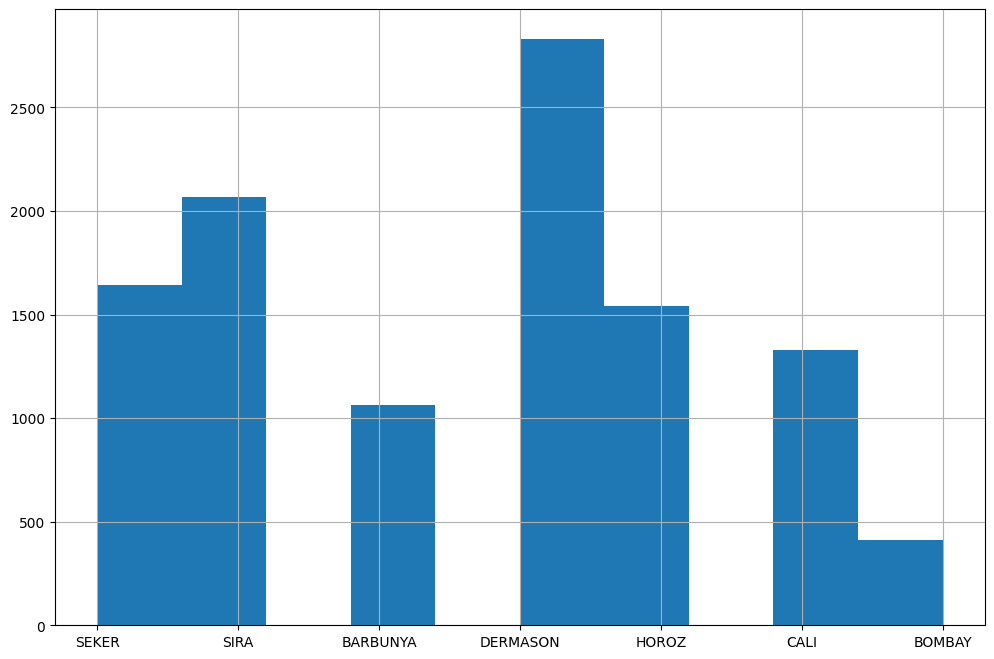

In [186]:
# Visualizamos la cantidad de objetos de cada clase
Drybean_train['Class'].hist(figsize=(12, 8))
plt.show()

Viendo la diferencia en la cantidad de datos de cada clase, procedemos a hacer un balanceo de estas.

In [187]:
mean = 1600

# Definimos el sobremuestreo y submuestreo para clases específicas
over_sampler = RandomOverSampler(sampling_strategy={'BOMBAY': mean, 'CALI': mean, 'BARBUNYA':mean})
under_sampler = RandomUnderSampler(sampling_strategy={'DERMASON': mean, 'SIRA':mean})

In [188]:
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
X_train, y_train = over_sampler.fit_resample(X_train, y_train)

**Boxplots de las variables**

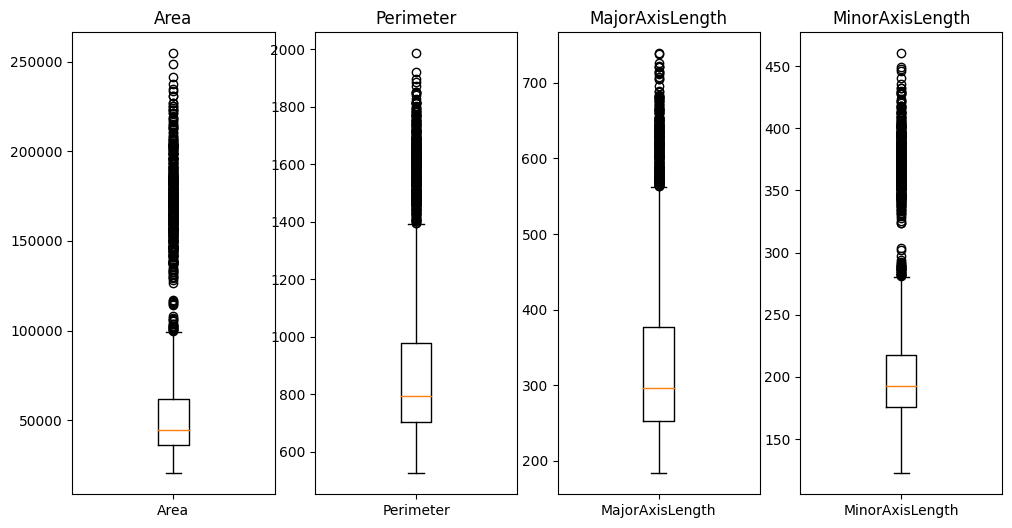

In [189]:
# Boxplots columnas 'Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength'
plot_boxplots(Drybean_train, ['Area', 'Perimeter', 'MajorAxisLength','MinorAxisLength'])

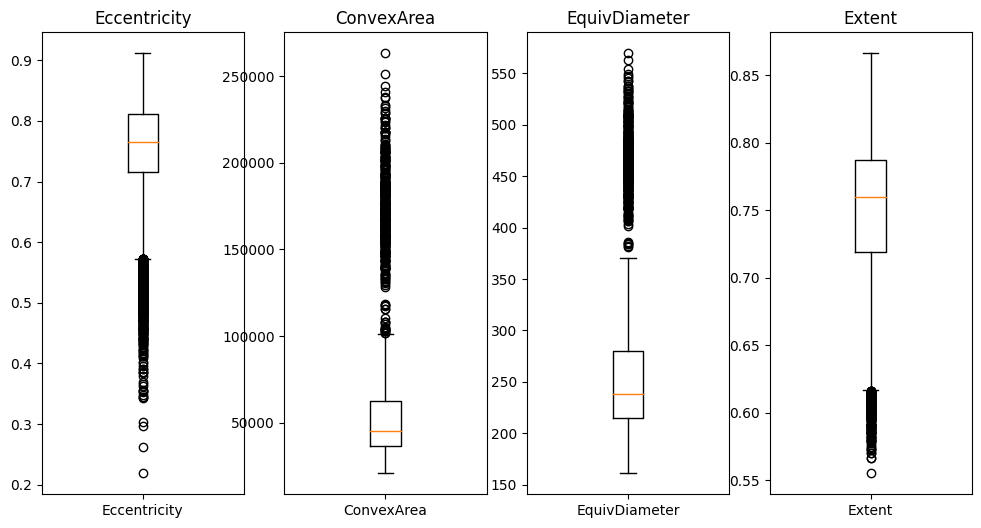

In [190]:
# Boxplots columnas 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent'
plot_boxplots(Drybean_train, ['Eccentricity', 'ConvexArea', 'EquivDiameter','Extent'])

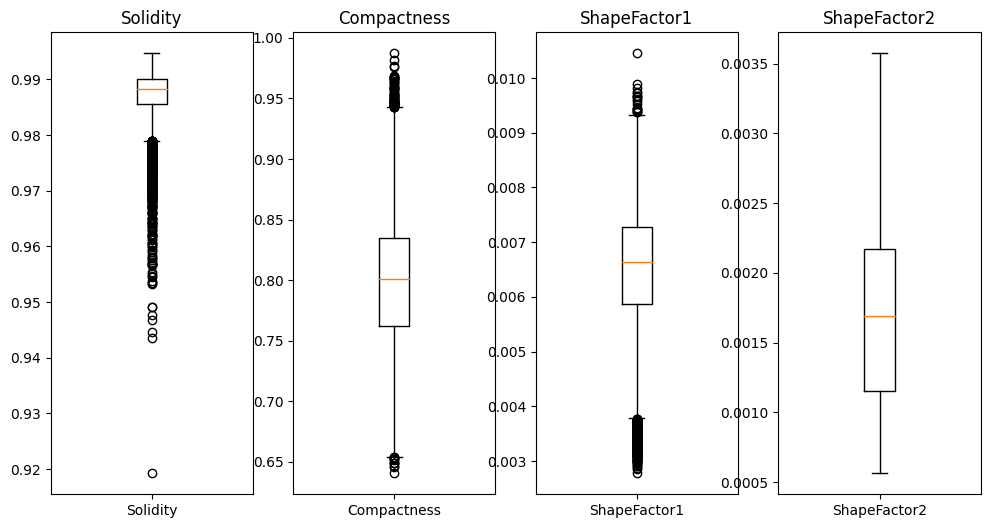

In [191]:
# Boxplots columnas 'Solidity', 'Compactness', 'ShapeFactor1', 'ShapeFactor2'
plot_boxplots(Drybean_train, ['Solidity', 'Compactness', 'ShapeFactor1','ShapeFactor2'])

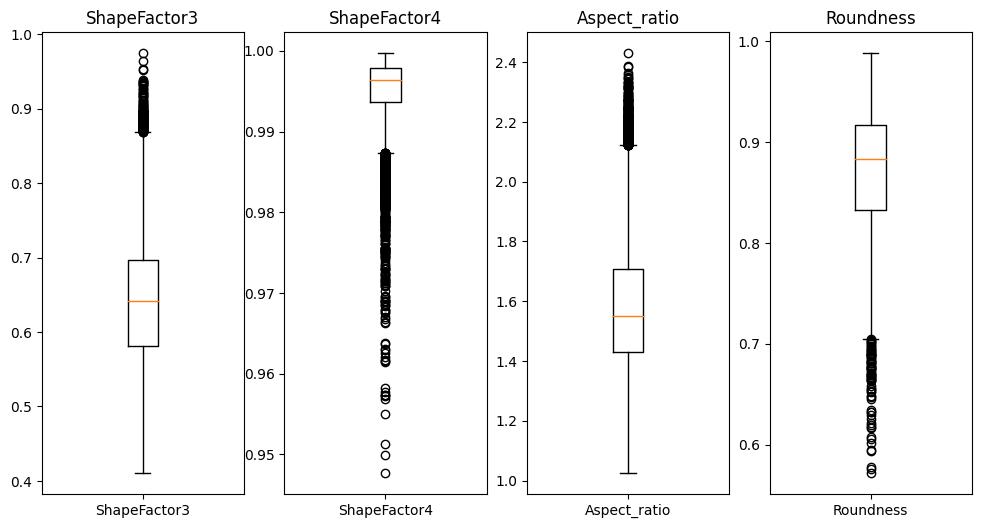

In [192]:
# Boxplots columnas 'ShapeFactor3', 'ShapeFactor4', 'Aspect_ratio', 'Roundness'
plot_boxplots(Drybean_train, ['ShapeFactor3', 'ShapeFactor4', 'Aspect_ratio','Roundness'])

A través de boxplots, pudimos observar las distribuciones de las distintas variables. Se presentan algunos valores inusuales, pero consideramos que no se tratan de valores atípicos, sino frijoles secos con distintas características al resto.

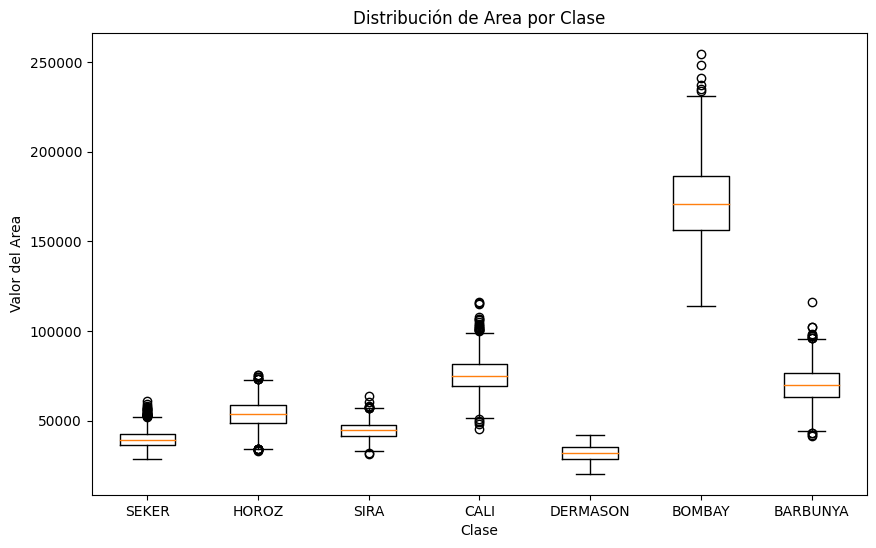

In [193]:
#Vemos como el tamaño del area influye en cada clase
plt.figure(figsize=(10, 6))
plt.boxplot([Drybean_train[Drybean_train['Class'] == 'SEKER']['Area'],
             Drybean_train[Drybean_train['Class'] == 'HOROZ']['Area'],
             Drybean_train[Drybean_train['Class'] == 'SIRA']['Area'],
             Drybean_train[Drybean_train['Class'] == 'CALI']['Area'],
             Drybean_train[Drybean_train['Class'] == 'DERMASON']['Area'],
             Drybean_train[Drybean_train['Class'] == 'BOMBAY']['Area'],
             Drybean_train[Drybean_train['Class'] == 'BARBUNYA']['Area']],
            labels=['SEKER', 'HOROZ', 'SIRA', 'CALI', 'DERMASON', 'BOMBAY', 'BARBUNYA'])
plt.xlabel('Clase')
plt.ylabel('Valor del Area')
plt.title('Distribución de Area por Clase')
plt.show()

In [194]:
# Vemos la matriz de correlación
Drybean_sin_clase = Drybean_train.drop('Class', axis=1)
Drybean_sin_clase.corr()

Area  Perimeter  MajorAxisLength  MinorAxisLength  \
Area             1.000000   0.966515         0.931953         0.951376   
Perimeter        0.966515   1.000000         0.977243         0.913329   
MajorAxisLength  0.931953   0.977243         1.000000         0.826402   
MinorAxisLength  0.951376   0.913329         0.826402         1.000000   
Eccentricity     0.269708   0.392740         0.543410         0.021757   
ConvexArea       0.999937   0.967513         0.932755         0.951115   
EquivDiameter    0.984833   0.991324         0.961868         0.948579   
Extent           0.050395  -0.025199        -0.081959         0.142520   
Solidity        -0.198595  -0.306579        -0.287813        -0.157486   
Compactness     -0.270265  -0.408307        -0.569588        -0.017228   
ShapeFactor1    -0.847361  -0.864715        -0.773918        -0.947098   
ShapeFactor2    -0.640918  -0.768800        -0.860014        -0.473570   
ShapeFactor3    -0.274324  -0.409890        -0.569393        -0.021475   
ShapeFactor4    -0.352836  -0.427338        -0.480853        -0.261179   
Aspect_ratio     0.244032   0.386768         0.551639        -0.006968   
Roundness       -0.359523  -0.549655        -0.596795        -0.213424   

                 Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  \
Area                 0.269708    0.999937       0.984833  0.050395 -0.198595   
Perimeter            0.392740    0.967513       0.991324 -0.025199 -0.306579   
MajorAxisLength      0.543410    0.932755       0.961868 -0.081959 -0.287813   
MinorAxisLength      0.021757    0.951115       0.948579  0.142520 -0.157486   
Eccentricity         1.000000    0.271535       0.320648 -0.320247 -0.301113   
ConvexArea           0.271535    1.000000       0.985106  0.048525 -0.208363   
EquivDiameter        0.320648    0.985106       1.000000  0.024565 -0.234253   
Extent              -0.320247    0.048525       0.024565  1.000000  0.199111   
Solidity            -0.301113   -0.208363      -0.234253  0.199111  1.000000   
Compactness         -0.970619   -0.272184      -0.329525  0.355595  0.308571   
ShapeFactor1         0.017910   -0.847361      -0.892695 -0.138540  0.154822   
ShapeFactor2        -0.860180   -0.642546      -0.714619  0.239517  0.347760   
ShapeFactor3        -0.981271   -0.276266      -0.332250  0.348877  0.312271   
ShapeFactor4        -0.451076   -0.359347      -0.390240  0.156234  0.712285   
Aspect_ratio         0.924946    0.245655       0.305615 -0.371870 -0.272606   
Roundness           -0.721068   -0.364167      -0.437770  0.346048  0.607152   

                 Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  \
Area               -0.270265     -0.847361     -0.640918     -0.274324   
Perimeter          -0.408307     -0.864715     -0.768800     -0.409890   
MajorAxisLength    -0.569588     -0.773918     -0.860014     -0.569393   
MinorAxisLength    -0.017228     -0.947098     -0.473570     -0.021475   
Eccentricity       -0.970619      0.017910     -0.860180     -0.981271   
ConvexArea         -0.272184     -0.847361     -0.642546     -0.276266   
EquivDiameter      -0.329525     -0.892695     -0.714619     -0.332250   
Extent              0.355595     -0.138540      0.239517      0.348877   
Solidity            0.308571      0.154822      0.347760      0.312271   
Compactness         1.000000     -0.007416      0.868690      0.998696   
ShapeFactor1       -0.007416      1.000000      0.471226     -0.006370   
ShapeFactor2        0.868690      0.471226      1.000000      0.872713   
ShapeFactor3        0.998696     -0.006370      0.872713      1.000000   
ShapeFactor4        0.486696      0.246603      0.530501      0.486413   
Aspect_ratio       -0.987757      0.022517     -0.837724     -0.978726   
Roundness           0.766035      0.232845      0.781784      0.761199   

                 ShapeFactor4  Aspect_ratio  Roundness  
Area                -0.352836      0.244032  -0.359523  
Perimeter           -0.42733

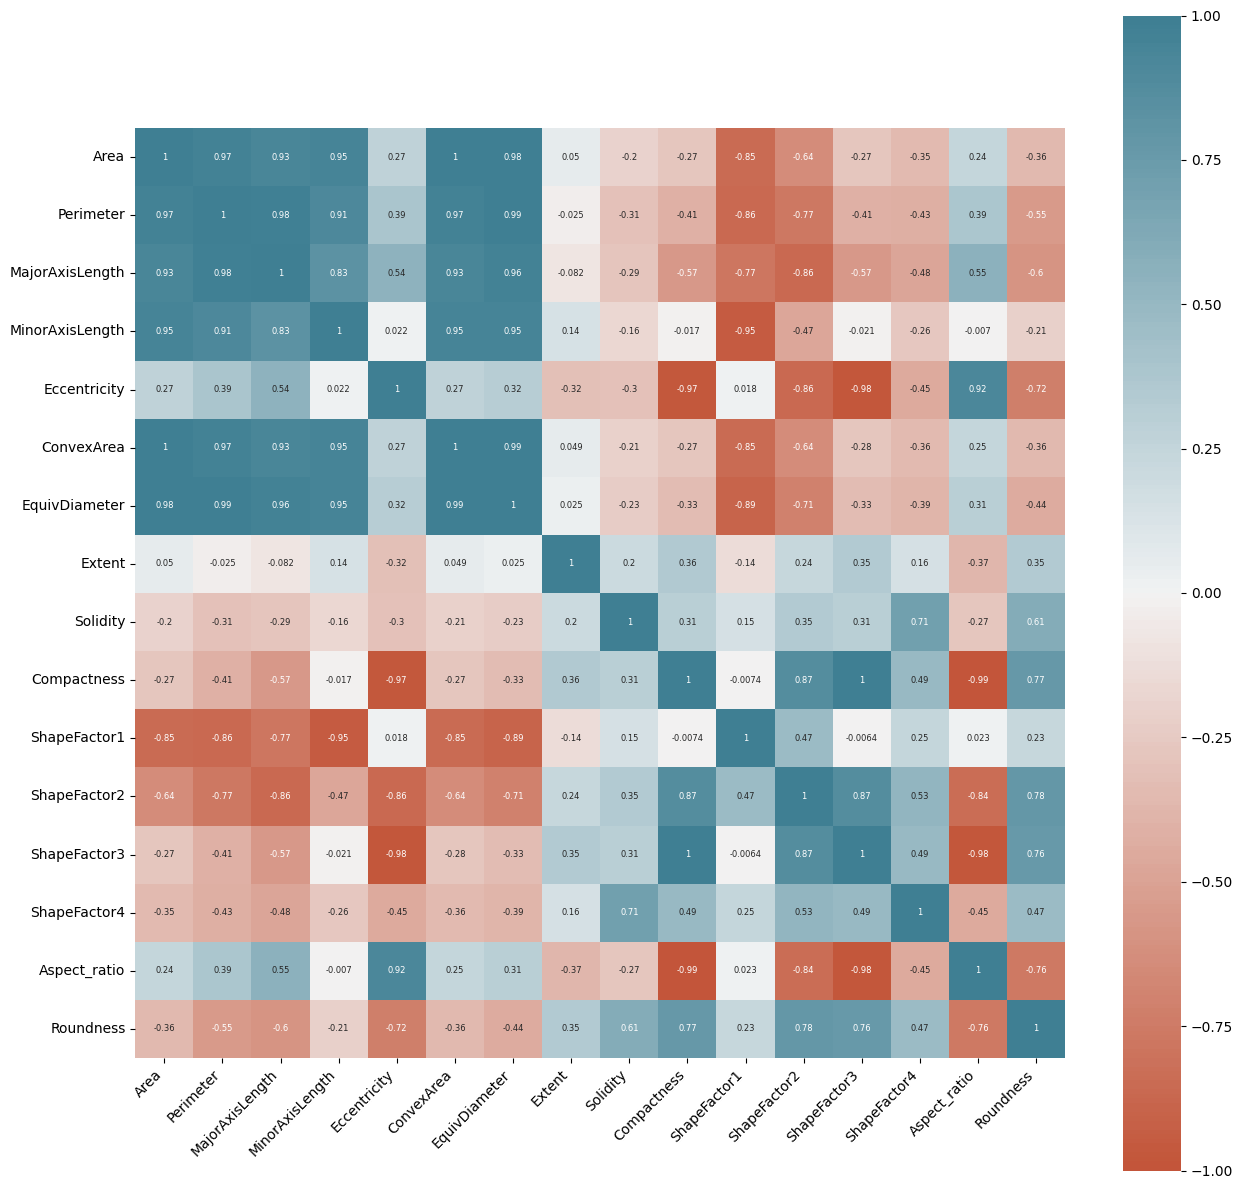

In [195]:
corr(Drybean_sin_clase)

Analizando los distintos niveles de correlación que hay entre las variables, podemos notar que algunos de los mas elevados son entre las variables `Perimeter`, `Area` , `MajorAxisLenght`, `MinorAxisLenght`, `ConvexArea`,`EquivDiameter`.

### **Preprocesamiento**

In [196]:
#Funcion de preprocesamiento de los datos
def preprocess_data(x, y, variable_objetive):
    y = pd.DataFrame(y)
    # Diccionario para mapear la variable categorica
    mapping = {'SEKER': int(0),
              'BARBUNYA': int(1),
              'BOMBAY' : int(2),
              'CALI': int(3),
              'HOROZ': int(4),
              'SIRA': int(5),
              'DERMASON': int(6),
              }

    # Aplicamos el mapeo a la columna 'Class'
    y.loc[:,'Class'] = y['Class'].map(mapping)
    y['Class'] = y['Class'].astype(int)

    # Calculamos el Aspect ratio (K) y la Roundness (R) para cada paciente en el dataset
    x['Aspect_ratio'] = x['MajorAxisLength'] / x['MinorAxisLength']
    x['Roundness'] = (4 * np.pi * x['Area']) / (x['Perimeter'] ** 2)

    # Defino un diccionario para definir el tipo de dato de cada columna
    column_types = {
        'Area': "float64",
        'Perimeter': "float64",
        'MajorAxisLength': "float64",
        'MinorAxisLength': "float64",
        'Eccentricity': "float64",
        'ConvexArea': "float64",
        'EquivDiameter': "float64",
        'Extent': "float64",
        'Solidity': "float64",
        'Compactness': "float64",
        'ShapeFactor1': "float64",
        'ShapeFactor2': "float64",
        'ShapeFactor3': "float64",
        'ShapeFactor4': "float64",
        'Aspect_ratio': "float64",
        'Roundness': "float64"
    }

    # Diccionario para almacenar media y desvío estándar de las columnas numéricas.
    numeric_stats = {}

    preprocessed_df = pd.DataFrame(x)

    # Preprocesamiento del set de entrenamiento
    for col_name, col_type in column_types.items():
      # Verifico si la columna está presente en el DataFrame
      if col_name in preprocessed_df.columns:
        # Obtengo el índice de la columna por su nombre
        col_values = preprocessed_df[col_name]
        col_mean = col_values.mean()
        col_std = col_values.std()

        # Normalizo la columna si es numérica
        if col_type == "int64":
            preprocessed_df[col_name] = (col_values - col_mean) / col_std

        # Almaceno media y desvío estándar
        numeric_stats[col_name] = {
            "mean": col_mean,
            "std": col_std
        }

    # Agrego la "variable_objetive" al dataset preprocesado
    preprocessed_df[variable_objetive] = y

    # Eliminamos valores nulos
    preprocessed_df = preprocessed_df.dropna()

    # x e y preprocesados
    x_processed = preprocessed_df.drop(variable_objetive, axis=1).values.astype(np.float32)
    y_processed = preprocessed_df[variable_objetive].values.astype(np.float32)

    return x_processed, y_processed

In [197]:
# Luego llamamos a la función para preprocesar los datos
X_train, y_train = preprocess_data(X_train, y_train, 'Class')

### **Modelo**

In [198]:
#Preprocesamos los datos de test
X_test, y_test = preprocess_data(X_test, y_test,'Class')

In [199]:
#Modelo
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(16,)),                                 # Numero de variables de entrada

    tf.keras.layers.Dense(units=100, activation='relu'),                # Capa oculta con 100 neuronas

    tf.keras.layers.Dense(units=100, activation=tf.nn.leaky_relu),      # Capa oculta con 100 neuronas

    tf.keras.layers.Dropout(0.15),                                      #15% de probabilidad de apagar neuronas en la capa anterior

    tf.keras.layers.Dense(units=60, activation=tf.nn.leaky_relu),       # Capa oculta con 60 neuronas

    tf.keras.layers.Dropout(0.05),                                      #0.5% de probabilidad de apagar neuronas en la capa anterior

    tf.keras.layers.Dense(units=30, activation=tf.nn.leaky_relu),       # Otra capa oculta con 30 neuronas

    tf.keras.layers.Dense(units=15, activation=tf.nn.leaky_relu),       # Otra capa oculta con 15 neuronas

    tf.keras.layers.Dense(units=7, activation='softmax')                # Capa de salida con 1 unidad y activación softmax
])

# Optimizador Adam para el entrenamiento del modelo.
optimizer = tf.keras.optimizers.Adam()

model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 100)               1700      
                                                                 
 dense_27 (Dense)            (None, 100)               10100     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_28 (Dense)            (None, 60)                6060      
                                                                 
 dropout_13 (Dropout)        (None, 60)                0         
                                                                 
 dense_29 (Dense)            (None, 30)                1830      
                                                                 
 dense_30 (Dense)            (None, 15)               

In [200]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 200

# Entrena el modelo
history = model2.fit(x=X_train, y=y_train, epochs=EPOCHS, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/200
350/350 [==============================] - 4s 5ms/step - loss: 224.7894 - accuracy: 0.1401 - val_loss: 7.5630 - val_accuracy: 0.0397 - lr: 0.0010
Epoch 2/200
350/350 [==============================] - 2s 5ms/step - loss: 6.5969 - accuracy: 0.1770 - val_loss: 2.8019 - val_accuracy: 0.1385 - lr: 0.0010
Epoch 3/200
350/350 [==============================] - 2s 5ms/step - loss: 2.8607 - accuracy: 0.2270 - val_loss: 1.9874 - val_accuracy: 0.2115 - lr: 0.0010
Epoch 4/200
350/350 [==============================] - 2s 6ms/step - loss: 2.3600 - accuracy: 0.2548 - val_loss: 2.2122 - val_accuracy: 0.3015 - lr: 0.0010
Epoch 5/200
350/350 [==============================] - 2s 6ms/step - loss: 2.0209 - accuracy: 0.2955 - val_loss: 1.6915 - val_accuracy: 0.3739 - lr: 0.0010
Epoch 6/200
350/350 [==============================] - 2s 6ms/step - loss: 1.9038 - accuracy: 0.2986 - val_loss: 1.7857 - val_accuracy: 0.2842 - lr: 0.0010
Epoch 7/200
350/350 [==============================] - 2s 5ms/

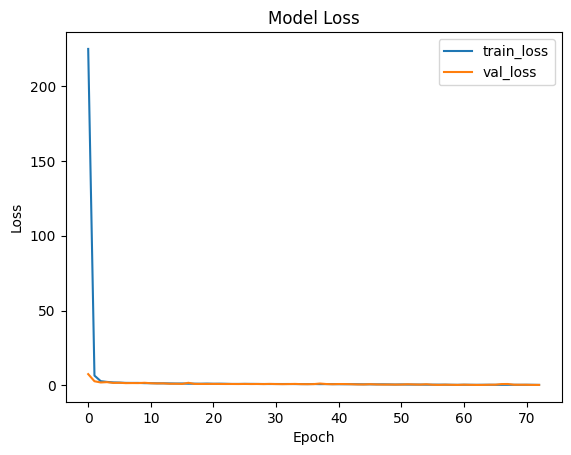

In [201]:
# Pérdida durante el entrenamiento
loss = history.history['loss']


# Gráfica de la pérdida en función de las épocas
plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

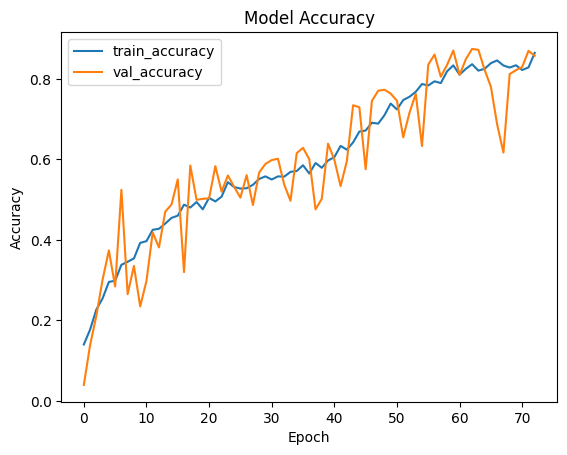

In [202]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']


# Graficar la precisión
plt.plot(accuracy_train, label='train_accuracy')
plt.plot(accuracy_val, label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Observando la evolución del loss y la accuracy durante el entrenamiento, se pueden extraer las siguientes conclusiones:


*   `Convergencia del loss`: Tanto en el conjunto de entrenamiento como en el de validación, el loss disminuye de forma consistente a lo largo de las épocas.

*   `Precisión del modelo`: La accuracy del conjunto de validación presenta fluctuaciones a lo largo del entrenamiento, en ocasiones superando e incluso quedando por debajo de la accuracy del conjunto de entrenamiento. Pero se puede notar la mejora de la métrica a lo largo de las épocas.


----

----

----

-----

# Problema 3


En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.


El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

*   `buildings`
*   `forest`
*   `glacier`
*   `mountain`
*   `sea`
*   `street`

Las imágenes están divididas en tres conjuntos:

*   `Train`: Alrededor de 14,000 imágenes para entrenamiento.
*   `Test`: Alrededor de 3,000 imágenes para evaluación del modelo.
*   `Prediction`: Alrededor de 7,000 imágenes para predicción final.





### Cargamos los dataset

In [6]:
# Directorio de los datos
DATA_DIRECTORY_TRAIN = Path("TP1-3/seg_train/seg_train")
DATA_DIRECTORY_TEST = Path("TP1-3/seg_test/seg_test")
DATA_DIRECTORY_PRED = Path("TP1-3/seg_pred/seg_pred")


# Tamaño del lote (batch size)
BATCH_SIZE = 64


# Tamaño de las imágenes
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Carga los datos de entrenamiento y test (validacion)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY_TEST,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


Visualizamos las clases

In [7]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Visualizamos ejemplos

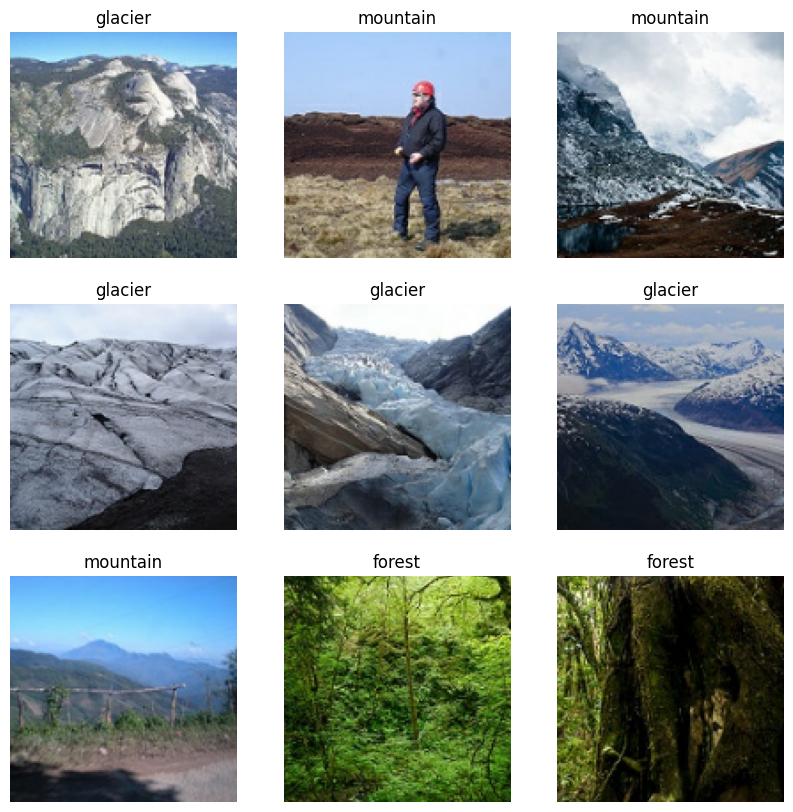

In [8]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

Mostrando imágenes de la clase: forest


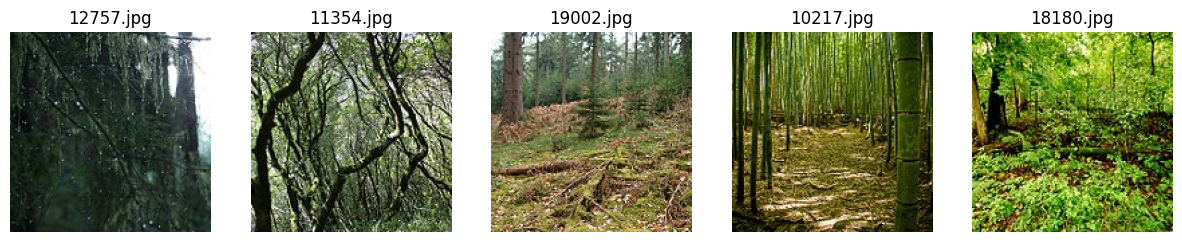

Mostrando imágenes de la clase: sea


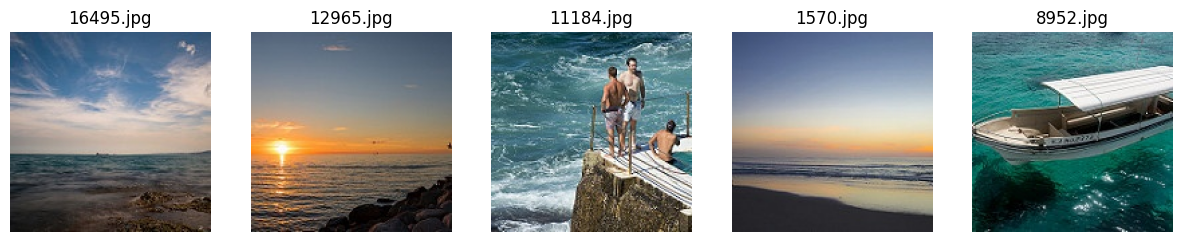

Mostrando imágenes de la clase: mountain


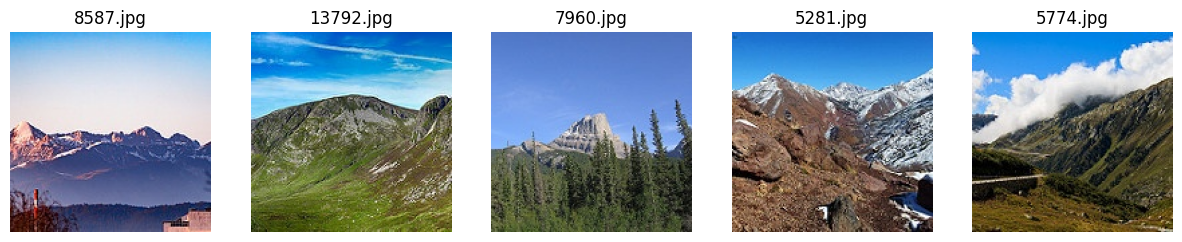

Mostrando imágenes de la clase: glacier


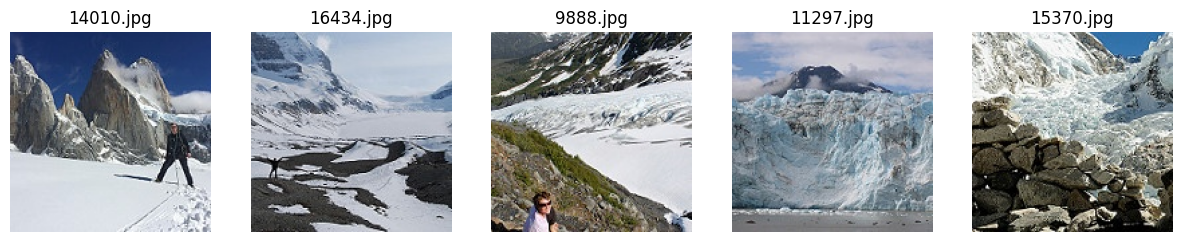

Mostrando imágenes de la clase: street


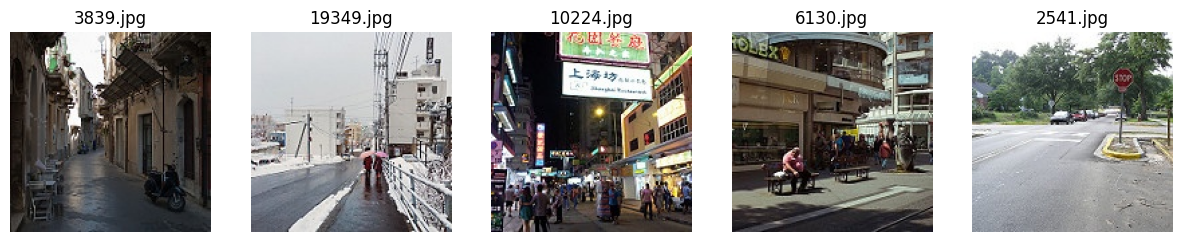

Mostrando imágenes de la clase: buildings


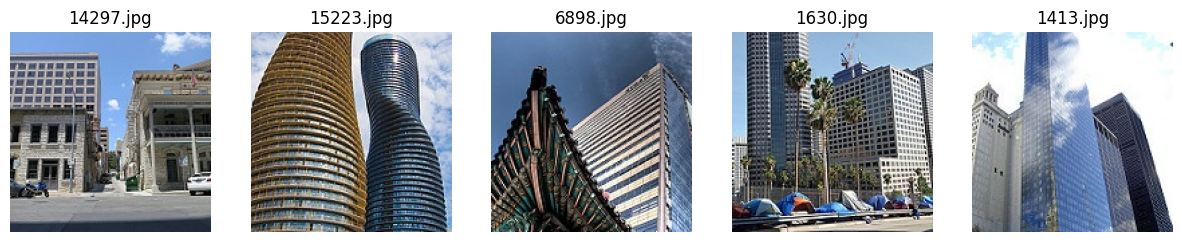

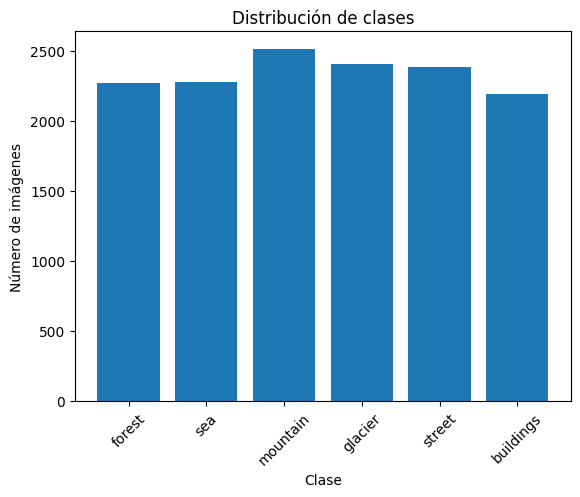

In [9]:
# Directorio que contiene las carpetas de clases
data_dir = DATA_DIRECTORY_TRAIN

# Lista de nombres de las clases (nombres de las carpetas)
classes = os.listdir(data_dir)

# Función para cargar y mostrar algunas imágenes de una clase específica
def show_images_from_class(class_name, num_images=5):
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)[:num_images]
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].set_title(img_name)
        axs[i].axis('off')
    plt.show()

# Mostrar algunas imágenes de cada clase
for class_name in classes:
    print(f"Mostrando imágenes de la clase: {class_name}")
    show_images_from_class(class_name)

# Histograma de distribución de clases
class_distribution = {class_name: len(os.listdir(os.path.join(data_dir, class_name))) for class_name in classes}
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Estadísticas básicas
image_sizes = []
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        width, height = img.size
        image_sizes.append((width, height))

image_sizes = np.array(image_sizes)
print("Estadísticas de tamaño de imagen:")
print(f"Tamaño mínimo: {np.min(image_sizes, axis=0)}")
print(f"Tamaño máximo: {np.max(image_sizes, axis=0)}")
print(f"Tamaño promedio: {np.mean(image_sizes, axis=0)}")
print(f"Tamaño mediano: {np.median(image_sizes, axis=0)}")

Estadísticas de tamaño de imagen:
Tamaño mínimo: [150  76]
Tamaño máximo: [150 150]
Tamaño promedio: [150.         149.90872168]
Tamaño mediano: [150. 150.]


### Preprocesamiento

In [11]:
# Funcion para preprocesar las imágenes
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img


#Funcion que toma un dataset de imagenes y un modelo, y hace la predicción de imagenes del dataset con el modelo.
def predicted_model(path_pred,model):

  # Lista de imagenes
  test_image_paths = list(path_pred.glob("*.jpg"))

  # Mostrar 5 imágenes con sus clases reales y previstas
  fig, axes = plt.subplots(1, 5, figsize=(15, 3))

  for i, ax in enumerate(axes):
      # Preprocesamos la imagen
      image_path = test_image_paths[i]
      image = preprocess_image(image_path)
      ax.imshow(image)
      ax.axis('off')

      image = np.expand_dims(image, axis=0)

      # Prediccion
      prediction = model.predict(image)
      predicted_class_index = np.argmax(prediction)
      predicted_class = class_names[predicted_class_index]


      # Resultados
      ax.set_title(f" Predicted: {predicted_class}")

  plt.tight_layout()
  plt.show()


## Modelo con capas densas

Arquitectura de la red

In [143]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Flatten()(x)

    x = Dense(90, activation=tf.nn.leaky_relu)(x)
    x = Dropout(0.3)(x)
    x = Dense(70, activation=tf.nn.leaky_relu)(x)
    x = Dense(30, activation='relu')(x)
    x = Dense(20, activation='relu')(x)

    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)

    return Model(inputs=[i], outputs=[x])


Construimos el modelo

In [144]:
print("Building model....")
model_dense = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Optimizador Adam para el entrenamiento del modelo.
optimizer = tf.keras.optimizers.Adam()

model_dense.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=['accuracy'])

print('Correctly constructed model')

Building model....
Correctly constructed model


In [145]:
#Resumen del modelo
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_translation (Random  (None, 128, 128, 3)       0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 128, 128, 3)       0         
 trast)                                                      

In [146]:
#Buscamos el mejor modelo desminuyendo el loss de validacion

early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-8, verbose=1, mode="min") # Frena cuando el val_loss deje de disminuir

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 200

# Entrenamos el modelo
history = model_dense.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/200
176/176 [==============================] - 18s 61ms/step - loss: 2.1880 - accuracy: 0.2443 - val_loss: 1.7005 - val_accuracy: 0.2867 - lr: 0.0010
Epoch 2/200
176/176 [==============================] - 8s 41ms/step - loss: 1.6046 - accuracy: 0.3113 - val_loss: 1.5500 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 3/200
176/176 [==============================] - 7s 40ms/step - loss: 1.5227 - accuracy: 0.3529 - val_loss: 1.4780 - val_accuracy: 0.3783 - lr: 0.0010
Epoch 4/200
176/176 [==============================] - 6s 33ms/step - loss: 1.4785 - accuracy: 0.3868 - val_loss: 1.4138 - val_accuracy: 0.4550 - lr: 0.0010
Epoch 5/200
176/176 [==============================] - 9s 44ms/step - loss: 1.4413 - accuracy: 0.4169 - val_loss: 1.3601 - val_accuracy: 0.4517 - lr: 0.0010
Epoch 6/200
176/176 [==============================] - 7s 40ms/step - loss: 1.4219 - accuracy: 0.4288 - val_loss: 1.3747 - val_accuracy: 0.4517 - lr: 0.0010
Epoch 7/200
176/176 [==============================] - 6s

Probamos el modelo

1/1 [==============================] - 0s 16ms/step


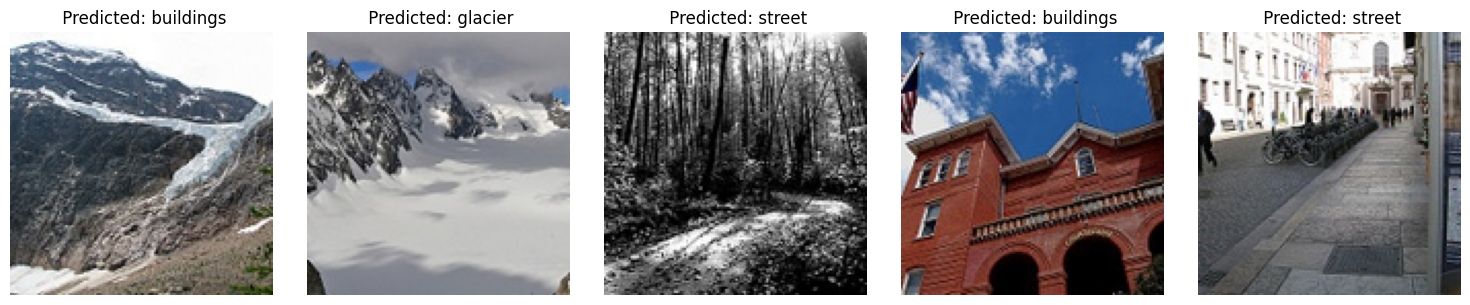

In [147]:
predicted_model(DATA_DIRECTORY_PRED,model_dense)

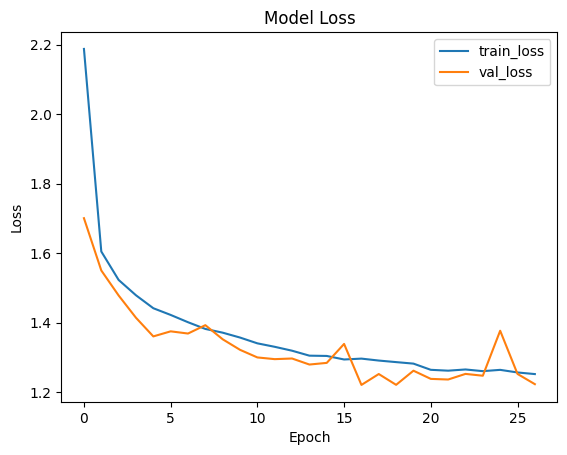

In [148]:
# Pérdida durante el entrenamiento
loss = history.history['loss']


# Gráfica de la pérdida en función de las épocas
plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

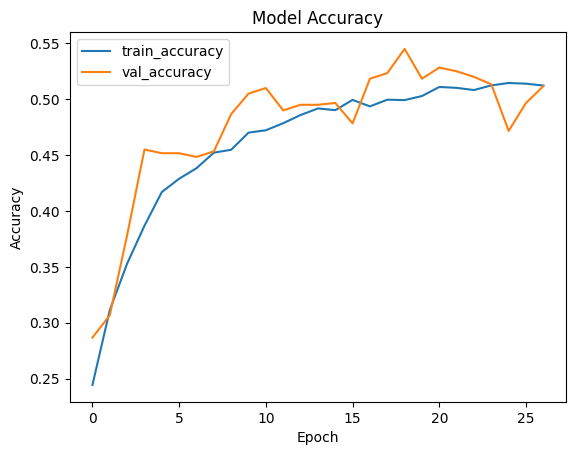

In [149]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']


# Graficar la precisión
plt.plot(accuracy_train, label='train_accuracy')
plt.plot(accuracy_val, label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Se puede observar el mal rendimiento del modelo, tanto en métricas como en resultados.

## Modelo con capas convolucionales y densas.

Arquitectura de la red

In [150]:
# Función para construir el modelo

def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])



Construimos el modelo

In [151]:
#Construimos el modelo

print("Building model")
model_conv_dense = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_conv_dense.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

print('Correctly constructed model')

Building model
Correctly constructed model


In [152]:
#Resumen del modelo

model_conv_dense.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_translation_1 (Rand  (None, 128, 128, 3)       0         
 omTranslation)                                                  
                                                                 
 random_contrast_1 (RandomC  (None, 128, 128, 3)       0         
 ontrast)                                                  

In [153]:
#Buscamos el mejor modelo desminuyendo el loss de validacion
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min") # Frena cuando el val_loss deje de disminuir

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 200


# Entrena el modelo
history = model_conv_dense.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/200
176/176 [==============================] - 15s 48ms/step - loss: 1.3638 - accuracy: 0.4323 - val_loss: 1.0221 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 2/200
176/176 [==============================] - 8s 46ms/step - loss: 1.0454 - accuracy: 0.5821 - val_loss: 0.9285 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 3/200
176/176 [==============================] - 8s 43ms/step - loss: 0.9846 - accuracy: 0.6057 - val_loss: 0.8121 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/200
176/176 [==============================] - 7s 41ms/step - loss: 0.8969 - accuracy: 0.6529 - val_loss: 0.7395 - val_accuracy: 0.7383 - lr: 0.0010
Epoch 5/200
176/176 [==============================] - 8s 47ms/step - loss: 0.8110 - accuracy: 0.6929 - val_loss: 0.6673 - val_accuracy: 0.7467 - lr: 0.0010
Epoch 6/200
176/176 [==============================] - 8s 46ms/step - loss: 0.7590 - accuracy: 0.7195 - val_loss: 0.7157 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 7/200
176/176 [==============================] - 7s

Probamos el modelo

1/1 [==============================] - 0s 17ms/step


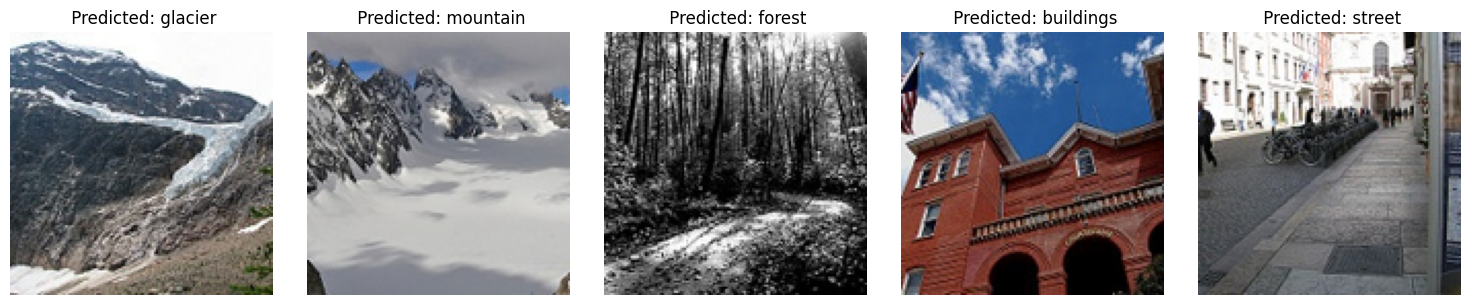

In [154]:
predicted_model(DATA_DIRECTORY_PRED,model_conv_dense)

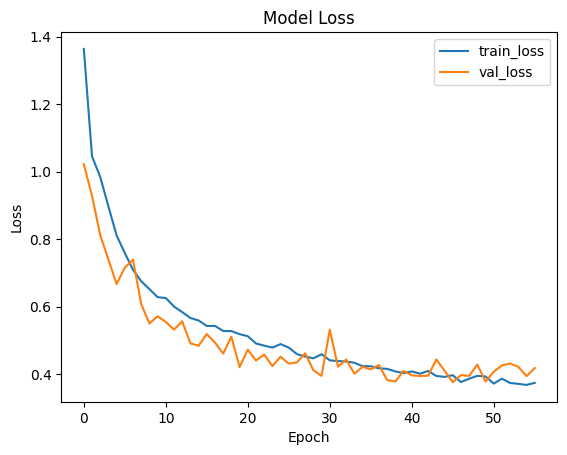

In [155]:
# Pérdida durante el entrenamiento
loss = history.history['loss']


# Gráfica de la pérdida en función de las épocas
plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

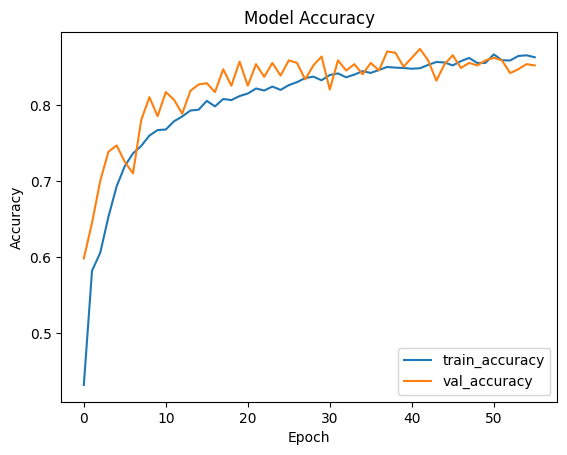

In [156]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']


# Graficar la precisión
plt.plot(accuracy_train, label='train_accuracy')
plt.plot(accuracy_val, label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Se puede notar, como a diferencia de la red con unicamente capas densas, la red en cuestión presenta métricas y resultados notoriamente superiores.

## Modelo que incluya bloques residuales identidad:


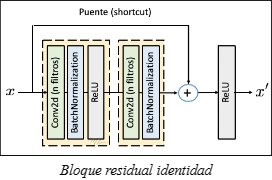

In [12]:
def residual_block(x, filters, strides=1):
  shortcut = x

  # Capa convolucional 1
  x = Conv2D(filters, (3, 3), strides=strides, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Dropout(0.30)(x)

  # Capa convolucional 2
  x = Conv2D(filters, (3, 3), padding="same")(x)
  x = BatchNormalization()(x)

  # Ajustamos el tamaño del shortcut si es necesario
  if strides != 1 or x.shape[-1] != shortcut.shape[-1]:
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
    shortcut = BatchNormalization()(shortcut)

  # Sumamos la entrada al resultado de las capas convolucionales
  shortcut = Conv2D(filters, (1, 1))(shortcut)
  x = Add()([x, shortcut])
  x = Activation("relu")(x)
  return x


def build_model(input_shape, output_labels):
  i = Input(input_shape, dtype=tf.float32)
  x = Rescaling(1./255)(i)
  x = RandomFlip("horizontal")(x)
  x = RandomFlip("vertical")(x)
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
  x = RandomContrast(0.2)(x)

  # Bloque convolucional inicial
  x = Conv2D(8, (3, 3))(x)
  x = Dropout(0.20)(x)
  x = Activation("relu")(x)
  x = Dropout(0.2)(x)
  x = MaxPooling2D((2, 2))(x)

  # Bloques residuales
  x = residual_block(x, 16)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 32)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 64)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 64)
  x = MaxPooling2D((2, 2))(x)
  x = residual_block(x, 128)
  x = MaxPooling2D((2, 2))(x)

  # Capa de salida
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = Dense(output_labels)(x)
  x = Activation("softmax")(x)

  return tf.keras.Model(inputs=[i], outputs=[x])

In [13]:
print("Building model")
model_residual = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_residual.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

print('Correctly constructed model')

Building model
Correctly constructed model


In [14]:
#Resumen del modelo
model_residual.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 random_flip (RandomFlip)    (None, 128, 128, 3)          0         ['rescaling[0][0]']           
                                                                                                  
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)          0         ['random_flip[0][0]']         
                                                                                              

In [15]:
#Buscamos el mejor modelo desminuyendo el loss de validacion
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 200

# Entrena el modelo
history = model_residual.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/200
176/176 [==============================] - 354s 2s/step - loss: 1.3058 - accuracy: 0.5033 - val_loss: 4.0797 - val_accuracy: 0.1600 - lr: 0.0010
Epoch 2/200
176/176 [==============================] - 338s 2s/step - loss: 0.9676 - accuracy: 0.6273 - val_loss: 2.3836 - val_accuracy: 0.2983 - lr: 0.0010
Epoch 3/200
176/176 [==============================] - 336s 2s/step - loss: 0.8517 - accuracy: 0.6719 - val_loss: 2.0415 - val_accuracy: 0.3917 - lr: 0.0010
Epoch 4/200
176/176 [==============================] - 336s 2s/step - loss: 0.7523 - accuracy: 0.7111 - val_loss: 1.2133 - val_accuracy: 0.6017 - lr: 0.0010
Epoch 5/200
176/176 [==============================] - 371s 2s/step - loss: 0.6991 - accuracy: 0.7348 - val_loss: 1.7115 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/200
176/176 [==============================] - 336s 2s/step - loss: 0.6459 - accuracy: 0.7596 - val_loss: 1.3291 - val_accuracy: 0.5433 - lr: 0.0010
Epoch 7/200
176/176 [==============================] - 337

1/1 [==============================] - 0s 27ms/step


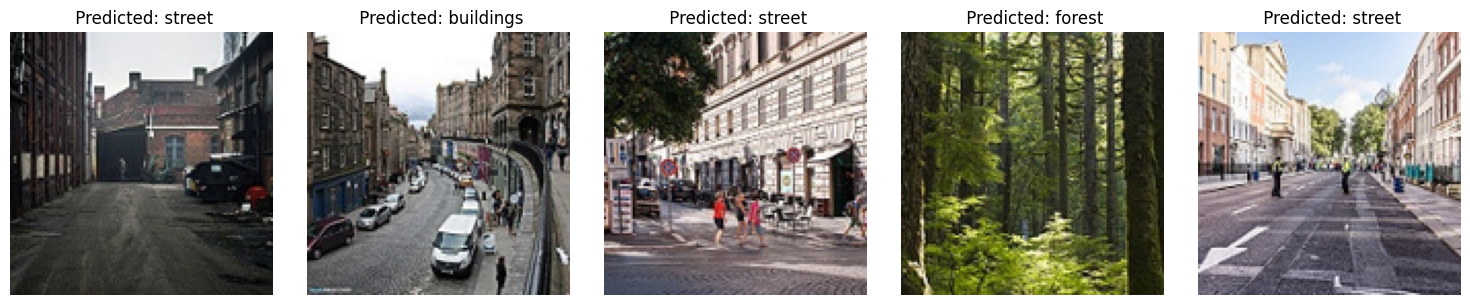

In [16]:
predicted_model(DATA_DIRECTORY_PRED,model_residual)

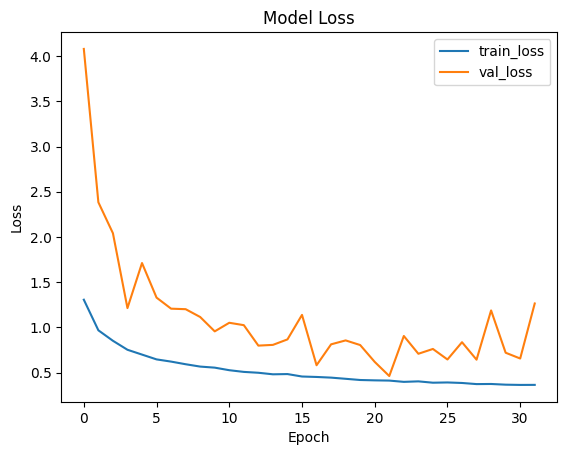

In [17]:
# Pérdida durante el entrenamiento
loss = history.history['loss']


# Gráfica de la pérdida en función de las épocas
plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

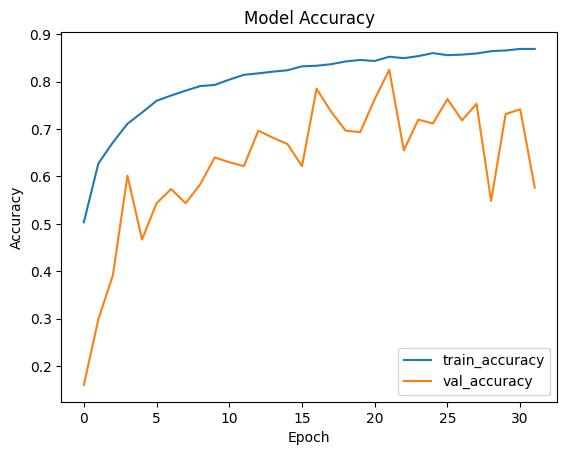

In [18]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']


# Graficar la precisión
plt.plot(accuracy_train, label='train_accuracy')
plt.plot(accuracy_val, label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

En esta red tenemos 11 capas convolucionales y si bien, podemos notar que las métricas son buenas, no son las mas óptimas.

## Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning):



Arquitectura de la red

In [220]:
def build_model(input_shape, num_classes):

    # Como modelo base utilizamos EfficientNetV2B0
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False


    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

Construimos el modelo

In [221]:
print("Building model")
model_tranf = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_tranf.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

print('Correctly constructed model')

Building model
Correctly constructed model


In [222]:
#Resumen del modelo
model_tranf.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 4, 4, 1280)        5919312   
 nal)                                                            
                                                                 
 global_max_pooling2d_1 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_26 (Dropout)        (None, 1280)              0         
                                                                 
 dense_34 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 5926998 (22.61 MB)
Trainable params: 7686 (30

In [223]:
#Entrenamos el modelo
early_stopping = EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-4, mode="min"
)

# Número de épocas de entrenamiento
EPOCHS = 200

# Entrena el modelo
history = model_tranf.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/200
176/176 [==============================] - 17s 57ms/step - loss: 0.8609 - accuracy: 0.7572 - val_loss: 0.3623 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 2/200
176/176 [==============================] - 8s 47ms/step - loss: 0.4711 - accuracy: 0.8567 - val_loss: 0.3322 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 3/200
176/176 [==============================] - 8s 47ms/step - loss: 0.3700 - accuracy: 0.8756 - val_loss: 0.3189 - val_accuracy: 0.8950 - lr: 0.0010
Epoch 4/200
176/176 [==============================] - 8s 41ms/step - loss: 0.3551 - accuracy: 0.8809 - val_loss: 0.3008 - val_accuracy: 0.9017 - lr: 0.0010
Epoch 5/200
176/176 [==============================] - 9s 50ms/step - loss: 0.3234 - accuracy: 0.8916 - val_loss: 0.3023 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 6/200
176/176 [==============================] - 9s 48ms/step - loss: 0.3078 - accuracy: 0.8928 - val_loss: 0.2983 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 7/200
176/176 [==============================] - 8s

Probamos el modelo

1/1 [==============================] - 0s 24ms/step


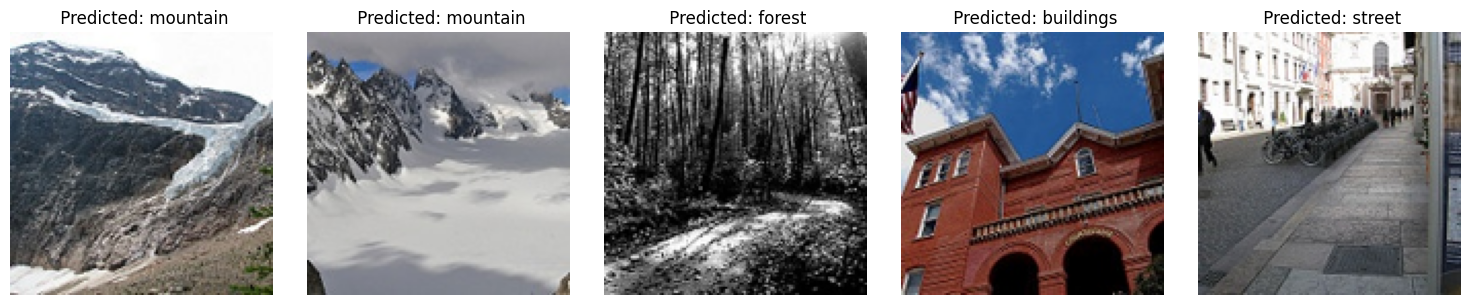

In [224]:
predicted_model(DATA_DIRECTORY_PRED,model_tranf)

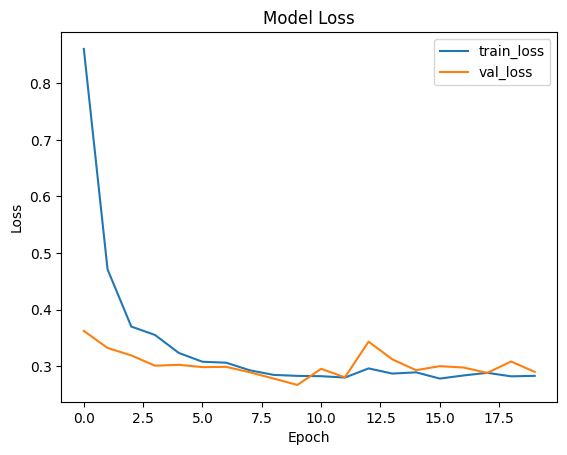

In [225]:
# Pérdida durante el entrenamiento
loss = history.history['loss']


# Gráfica de la pérdida en función de las épocas
plt.plot(loss, label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

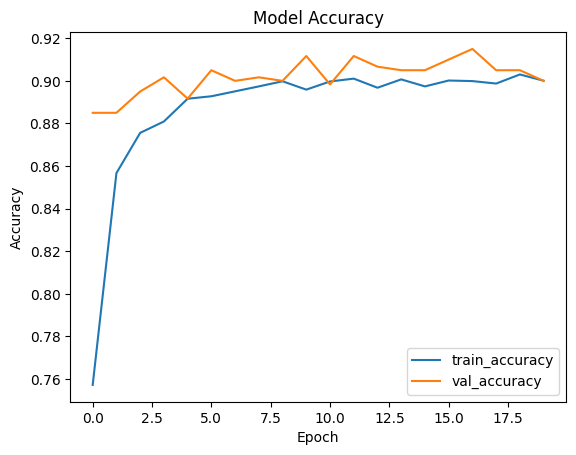

In [226]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']


# Graficar la precisión
plt.plot(accuracy_train, label='train_accuracy')
plt.plot(accuracy_val, label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Tanto en el conjunto de entrenamiento como en el de validación, el loss disminuye de forma consistente a lo largo de las épocas, y se puede notar un buen numero ya desde las primeras epocas.

Se puede notar la mejora de la accuracy a lo largo de las épocas. Y una correlacion entre train y test que deja ver que el modelo no overfitea.

# Conclusión final

A lo largo de los tres problemas, quedó en evidencia cómo las diferentes arquitecturas de redes neuronales se adaptan de manera distinta a cada situación y tipo de datos.

**Problema 1 (Predicción lineal)**:

La red neuronal densa fue efectiva para predecir la variable lineal del rendimiento académico. El dataset pequeño y la cantidad limitada de variables permitieron un buen rendimiento con una arquitectura simple, sin necesidad de complejidades adicionales.

**Problema 2 (Clasificación)**:

Similar al problema 1, el tamaño del dataset y la naturaleza de las variables (17 en total) llevaron a utilizar un modelo un poco más grande que en el problema 1, pero aún manejable. Se agregaron capas de dropout para evitar el sobreajuste.

**Problema 3 (Clasificación de imágenes)**:

Este problema permitió comparar directamente diferentes modelos en una tarea de clasificación de imágenes:


*   **Capas densas**: Mostraron un rendimiento deficiente, incluso variando su arquitectura.
*   **Capas convolucionales y densas**: Ofrecieron un rendimiento óptimo, especialmente con la arquitectura mostrada por la cátedra, demostrando la importancia de las capas convolucionales para procesar información espacial en imágenes.
*   **Bloques residuales**: También obtuvieron un buen rendimiento, destacando su utilidad en redes más profundas.
*  **Transfer learning**: El rendimiento varió según el modelo pre-entrenado,  resaltando la importancia de seleccionar la arquitectura base adecuada. Es por ello, que decidimos quedarnos con **EfficientNetV2B0**.


####**Conclusiones generales:**
La elección de la estructura de la red neuronal depende del tipo de datos y del problema. Redes densas pueden ser suficientes para datasets pequeños con pocas variables, mientras que las redes convolucionales son ideales para imágenes.
En base a lo trabajado, consideramos que la experimentación es clave para encontrar la mejor arquitectura.
Hemos visto que técnicas como dropout y bloques residuales ayudan a prevenir el sobreajuste y a entrenar redes más profundas.
